In [1]:
%load_ext autoreload
%autoreload 2

# Introduction

This notebook explores the shapelet transformers implemented within aeon.

Here you'll learn about the theory behind the shapelet transforms and get a first hand look at how shapelets can boost interpretability using our visualisation module.
- Highlight differences between the four transformers, in order of publishment
- Explain the Gun/No gun problem, this will help with interpreting shapelets later
- Visualise the time series from both classes
- for each transformer:
    - Time how long it takes to transform the data
    - Show how the data is transformed 
    - Explore how different classifiers rank shapelets (only on first transformer)
    - Visualise the extracted shapelets and group them by class
    - Show the best and worst shapelet for each class using Viz module
- Interpret the shapelets, try get some insight to the problem to understand classification.
- Summarise the differences between each transform

If you want to learn about shapelet classification then go to Antoines shapelet notebook found in examples\classification\shapelet_based.ipynb

# A little bit about each transformer

- talk about their params and logic and contributions and flaws (write in order of release)

In [2]:
import warnings

warnings.filterwarnings("ignore")

from aeon.registry import all_estimators

for k, v in all_estimators("transformer", filter_tags={"algorithm_type": "shapelet"}):
    print(f"{k}: {v}")

RSAST: <class 'aeon.transformations.collection.shapelet_based._rsast.RSAST'>
RandomDilatedShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._dilated_shapelet_transform.RandomDilatedShapeletTransform'>
RandomShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._shapelet_transform.RandomShapeletTransform'>
SAST: <class 'aeon.transformations.collection.shapelet_based._sast.SAST'>


## Shapelet transform
One ground breaking introduction the STC made was the notion of `transform` where the time series data would be transformed into a seperate feature space fed to the classifier. The primitive shapelet algorithm could only use a classification tree where at each level a shapelet was used to maximise the information gain. This novel transformation enabled decoupling the shapelet generation from classification, which in practise means you can use our transforms with any scikit-learn classifier!

STC seperates the shapelet learning phase from the classification phase, meaning the transform can be used with any supervised classifier. This improved the accuracy compared to the initial shapelet tree.

It does have a relativley high time complexity due to the large number of shapelet candidaates which must be evaluated in the search for best shapelets.

## Random Dilated Shapelet Transform
This algorithm introduces two further features for each shapelet within the transformed feature space. Knowing where a shapelet is most closely fit to each time series and how many times the shapelet appears in a time series increases the discriminative ability of classifiers. More notably, this algorithm can genearate stretch and compress shapelets (known as dilation) which plays the role of downsampling and can mitigate noise.

## Scalable and Accurate Subsequence Transform

- exploit the fact that shapelets are shared by members of the same class, so this algorithms avoids learning redundant shapelets.
- any instance of a class should contain all the shapelet candidates (or atleast a variant) for that class.

The previous two transforms used the whole training set to generate shapelet candidates, then used a quality measure to select the best shapelets. SAST claims that this shapelet evaluation is a redundant step which the classifier inherently does through feature importance. So its use is for interpretability which can be done post hoc, in fact selecting shapelets independelty of the classifier harms performance.

inspired by 'core object recognition' where our brain only needs one or a few instances to recognise objects. This is also true for finding shapelets which will be by defitions present in all instances of a class. The model's perfromance does improve as the number of reference time series grows but this is at risk of  overfitting

STC learns redundant shapelets which vary in length, starting position and shape which are all still the same pattern. Avoid learning different variants of the same pattern by limitting the number of reference time series per class.

By transforming the space using all subsequences you simply either find a discriminative subsequence or one that is not. The classifier learns to pay less attention to the unifinformative features. I guess the downside is the risk of the curse of dimensionaility.

## Random Scalable and Accurate Subsequence Transform
Based on SAST, it uses a stratified sampling strategy
    for subsequences selection but additionally takes into account certain
    statistical criteria such as to further reduce
    the search space of shapelets.

RSAST starts with the pre-computation of a list of weights, using ANOVA,
    which helps in the selection of initial points for subsequences. Then
    randomly select k time series per class, which are used with an ACF and PACF,
    obtaining a set of highly correlated lagged values. These values are used as
    potential lengths for the shapelets. Lastly, with a pre-defined number of
    admissible starting points to sample, the shapelets are extracted and used to
    transform the original dataset, replacing each time series by the vector of its
    distance to each subsequence.

# The Gunpoint classification problem

The Gun/NoGun motion capture time series dataset is perhaps the most studied time
series classification problem in the literature.

This dataset involves one female actor and one male actor making a motion with their hand, sometimes holding a gun and sometimes not. The classification problem is to determine whether or not they were holding a prop or just miming the action. The problem is made somewhat more complicated by the fact that the two actors, differ in height (by 12 inches) and “style”.

The two classes are:

Gun-Draw:
- the actors have their hands by their sides. They draw a replicate gun from a hip-mounted holster, point it at a target for approximately one second, then return the gun to the holster, and their hands to their sides. 

Point:
- the actors have their gun by their sides. They point with their index fingers to a target for approximately one second, and then return their hands to their sides. 

For both classes, they study tracked the centroid of the actor's right hand in both X- and Y-axes, which appear to be highly correlated. Because of this, the data in the archive is just the X-axis - making this a univariate time series. Class 1 is "gun" and class 2 is "no gun (pointing)".

In [3]:
import numpy as np

from aeon.datasets import load_classification

X_gun_train, y_gun_train = load_classification("GunPoint", split="train")
X_gun_test, y_gun_test = load_classification("GunPoint", split="test")

X_gun_full = np.concatenate((X_gun_train, X_gun_test), axis=0)

print(f"Shape of the dataset: {X_gun_full.shape}")
print(f"Number of channels = {X_gun_train.shape[1]}")
print(f"Length of each time series = {X_gun_train.shape[2]}")
print(f"Number of training samples = {X_gun_train.shape[0]}")
print(f"Number of testing samples = {X_gun_test.shape[0]}")

Shape of the dataset: (200, 1, 150)
Number of channels = 1
Length of each time series = 150
Number of training samples = 50
Number of testing samples = 150


As you can see, we have 200 different time series, each 150 datapoints long. The train/test split follows the original paper with 50 samples taken for training and the rest for testing, with each actor and class being equally represented in each. 

Note: Time series classification follows its on train/test split rather than the more general 70/30 found in wider ML. Eamonn, who was setting up the archive, chose to make the train sets smaller so that the classification problems would even harder to solve!

---


The two graphs below have the time series from the dataset plotted for each class.

*can we find a big difference between class 1 and 2?*  ---- The narrative will be that the data is noisy and so trying to use global patterns would make this pretty hard, instead shapelets will let us find locally discriminative subsequences to distinguish the two

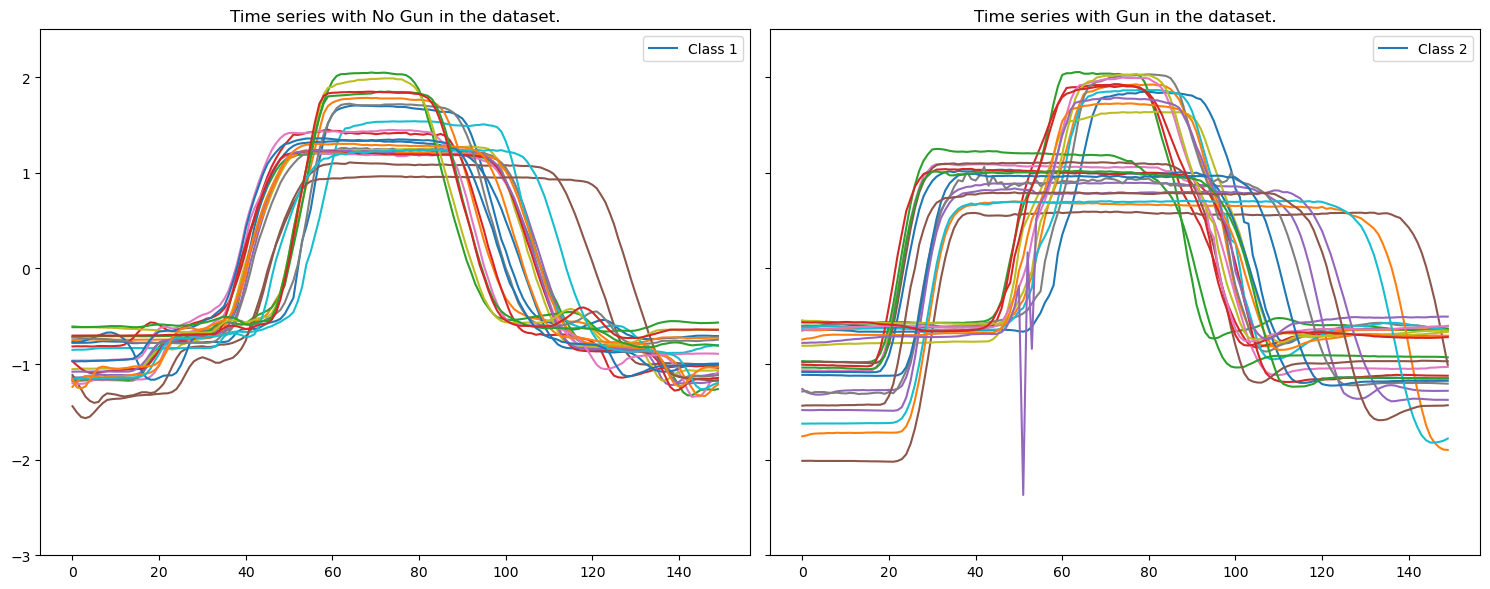

In [4]:
import matplotlib.pyplot as plt

class_1_indices = []
class_2_indices = []

# Populate the class-specific lists
for i in range(0, 50):
    if y_gun_train[i] == "1":
        class_1_indices.append(i)
    elif y_gun_train[i] == "2":
        class_2_indices.append(i)

# Create a figure arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot the first class
for i in class_1_indices:
    axs[0].plot(X_gun_train[i][0])
axs[0].set_title("Time series with No Gun in the dataset.")
axs[0].set_ylim(-3, 2.5)  # Set the y-axis range for comparability
axs[0].legend(["Class 1"])

# Plot the second class
for i in class_2_indices:
    axs[1].plot(X_gun_train[i][0])
axs[1].set_title("Time series with Gun in the dataset.")
axs[1].set_ylim(-3, 2.5)  # Set the y-axis range for comparability
axs[1].legend(["Class 2"])

plt.tight_layout()
plt.show()

You can roughly make out the groups of time series of the female and male actor, as described in the dataset the male is 12 inches taller which can be seen by the taller and shorter time series groups

# Exploring each transform's shapelets

Here is a dataframe representing the testing data, each row is a time series and each column is the value at each time point. 

In [5]:
import pandas as pd

timeseries_list = []
for timeseries in X_gun_test:
    timeseries_list.append(pd.DataFrame(timeseries))
pd.concat(timeseries_list, axis=0, ignore_index=True)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-1.125013,-1.131338,-1.138288,-1.146687,-1.138639,-1.141431,-1.143691,-1.144379,-1.154912,-1.146421,...,-1.205572,-1.281235,-1.323420,-1.345800,-1.344547,-1.301098,-1.265903,-1.212717,-1.206178,-1.218422
1,-0.626956,-0.625919,-0.627538,-0.626326,-0.624085,-0.624708,-0.625006,-0.624175,-0.624018,-0.622033,...,-0.620019,-0.621505,-0.621526,-0.624091,-0.623989,-0.624350,-0.624376,-0.619471,-0.612058,-0.606422
2,-2.001163,-1.999575,-1.999537,-1.999196,-1.999004,-2.000315,-1.998425,-2.000679,-1.999995,-2.000786,...,0.312798,0.242217,0.145716,0.014012,-0.151780,-0.333427,-0.577435,-0.812720,-1.071147,-1.323383
3,-1.004587,-0.999843,-0.995250,-0.992019,-0.991200,-0.987556,-0.996473,-0.996878,-0.998673,-0.997882,...,-1.080245,-1.060166,-1.044471,-1.039528,-1.040693,-1.044162,-1.044058,-1.044916,-1.044226,-1.043262
4,-0.742625,-0.743770,-0.743900,-0.744873,-0.744745,-0.745364,-0.747078,-0.746615,-0.746705,-0.745859,...,-0.699312,-0.696897,-0.694059,-0.689150,-0.687534,-0.682798,-0.682153,-0.681030,-0.670519,-0.657403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.580006,-0.583332,-0.586108,-0.589118,-0.591951,-0.599196,-0.609292,-0.618504,-0.627164,-0.635995,...,-0.536779,-0.537708,-0.537554,-0.538319,-0.538915,-0.541542,-0.545838,-0.546621,-0.548831,-0.553552
146,-0.728153,-0.730242,-0.733560,-0.734188,-0.734331,-0.734660,-0.733856,-0.733397,-0.732929,-0.731822,...,-0.788042,-0.768710,-0.748156,-0.728561,-0.711126,-0.699604,-0.689584,-0.687476,-0.686448,-0.690183
147,-0.738012,-0.736301,-0.731226,-0.728455,-0.728883,-0.727372,-0.724525,-0.720916,-0.719828,-0.719228,...,-0.617504,-0.613856,-0.611590,-0.609785,-0.609814,-0.608848,-0.610023,-0.609646,-0.608616,-0.612177
148,-1.265111,-1.256093,-1.259421,-1.256351,-1.253265,-1.260103,-1.265063,-1.256396,-1.246350,-1.249132,...,-1.192413,-1.193333,-1.195697,-1.189598,-1.177099,-1.188014,-1.189629,-1.199970,-1.193374,-1.192835


#### Random Shapelet Transform

The aeon implementation of the algorithm matches the experimental parameters explored in the Gunpoint problem, the only parameter which was required to be set was max_shapelets = 10. 

The paper filtered the GunPoint data set using the
length parameters specified in the original shapelet paper to allow for
a fair comparison between the two methods. For MAXLEN, the original always set the longest possible length to the length of
the shortest time series in the dataset. For MINLEN, they hardcoded the shortest possible length to three since three is the minimum meaningful length. 


You can use the transform directly in aeon, but we will mostly explore via the transform classifier because it lets us rank the shapelets.

In [6]:
import time

import pandas as pd

from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

start_time = time.time()
rst = RandomShapeletTransform(max_shapelets=10, random_state=99).fit(
    X_gun_train, y_gun_train
)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

pd.DataFrame(rst.transform(X_gun_test))

Time taken to fit: 10.4051 seconds


,0,1,2,3,4,5,6,7,8,9
0,0.003717,0.020089,0.043620,1.320980,0.001551,0.008399,0.838023,1.004437,0.900919,0.089512
1,0.133435,0.150480,0.117333,0.033369,0.122150,0.114631,0.040733,0.239368,0.057699,0.009116
2,0.152721,0.193469,0.132979,1.079411,0.187685,0.217339,0.827136,0.935028,0.884864,0.246486
3,0.045800,0.028813,0.019837,1.356602,0.037309,0.026347,0.861129,1.034721,0.935163,0.078142
4,0.045097,0.038882,0.066422,1.358289,0.047304,0.031171,0.865805,1.015214,0.299602,0.051525
...,...,...,...,...,...,...,...,...,...,...
145,0.163862,0.204825,0.143582,0.366795,0.158322,0.149433,0.271026,0.872067,0.214193,0.009775
146,0.051390,0.038367,0.062432,1.337244,0.064614,0.039837,0.847953,1.000116,0.926387,0.049306
147,0.179117,0.217945,0.148447,0.062721,0.171713,0.158122,0.047981,0.259901,0.072351,0.008373
148,0.154436,0.176792,0.129151,0.954934,0.158068,0.166027,0.774495,0.911700,0.841725,0.262808


The table shows what the transformed data looks like. As you can see we still have 150 time series, the rows. But now, instead of the columns representing the value at each time point, the columns contain the shortest distance between each of the 10 shapelets and the time series.

The dataframe isn't very informative about the shapelets themselves. Lets look at the 10 best shapelets found which each happen to be one of the columns above.

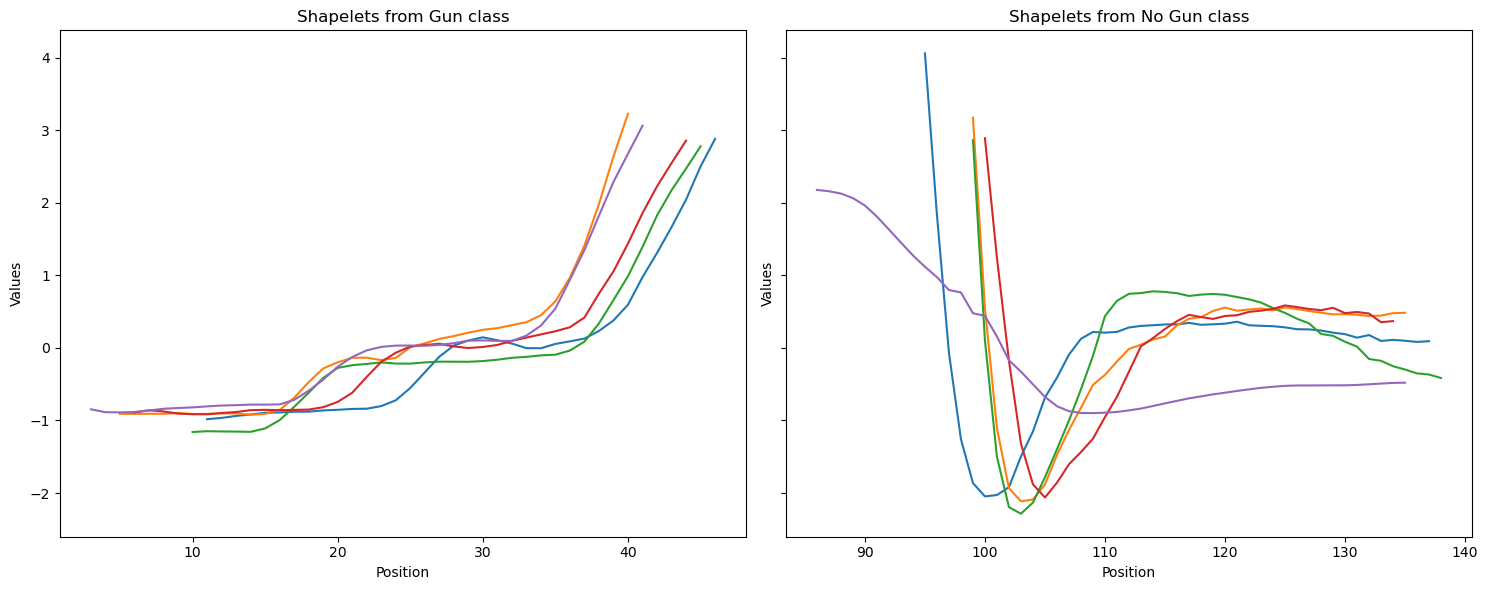

In [7]:
import matplotlib.pyplot as plt

# Define the class of interest
gun_class = "1"
nogun_class = "2"

shapelets = rst.shapelets


shapelet_gun_vals = []
shapelet_gun_pos = []

shapelet_nogun_vals = []
shapelet_nogun_pos = []

for shapelet in shapelets:
    if shapelet[5] == gun_class:  # Filter by class
        shapelet_gun_vals.append(shapelet[6])
        shapelet_gun_pos.append(shapelet[2])

for shapelet in shapelets:
    if shapelet[5] == nogun_class:  # Filter by class
        shapelet_nogun_vals.append(shapelet[6])
        shapelet_nogun_pos.append(shapelet[2])

# Create a figure with 2 subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot the first set of shapelets
for i in range(len(shapelet_gun_vals)):
    x_values = [x + shapelet_gun_pos[i] for x in range(len(shapelet_gun_vals[i]))]
    axs[0].plot(x_values, shapelet_gun_vals[i])

axs[0].set_title("Shapelets from Gun class")
axs[0].set_xlabel("Position")
axs[0].set_ylabel("Values")

# Plot the second set of shapelets
for i in range(len(shapelet_nogun_vals)):
    x_values = [x + shapelet_nogun_pos[i] for x in range(len(shapelet_nogun_vals[i]))]
    axs[1].plot(x_values, shapelet_nogun_vals[i])

axs[1].set_title("Shapelets from No Gun class")
axs[1].set_xlabel("Position")
axs[1].set_ylabel("Values")


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

We have two very distint groups of shapelets found, those in the first half and those in the second half of the time series. In fact these two groups correspond to a class. Here we have learned that the two classes can be distinguished by th estart ad end of the movement in the Gunpoint action.


shows that the top ten shapelets form two
distinct clusters. Interestingly, the shapelets to the left of the
figure correspond to the moments where the arm is lifted and
are instances where there is a gun. These shapelets could
correspond to the subtle extra movements required to lift the
prop, aiding classification by providing more information.


we can see that the NoGun class has a “dip” where the actor puts her hand down by
her side, and inertia carries her hand a little too far and she is forced to correct for it
(a phenomenon known as “overshoot”). In contrast, when the actor has the gun, she
returns her hand to her side more carefully, feeling for the gun holster, and no dip is
seen.

In [ ]:
from collections import Counter

shapelets = rst.shapelets
classes = []
for shapelet in shapelets:
    classes.append(shapelet[5])
Counter(classes)

# Here we can see that the RST has made 5 shapelets for each class
# docstring says Each class value will have its own max,
# set to n_classes / max_shapelets - enforcing same amount

Now lets take a look at how important classifiers find these shapelets relative to one another. We are training a Ridge CV and a Random Forest on the transformed data. I emphasise that the purpose is not to evaluate classification performance but to make use of the feature importance provided by the classifier to aid in comparing shapelets further on.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV

from aeon.classification.shapelet_based import ShapeletTransformClassifier

rst_rf = ShapeletTransformClassifier(
    estimator=RandomForestClassifier(ccp_alpha=0.01),
    max_shapelets=10,
    random_state=99,  # Same random state as for the individual transform from above
).fit(X_gun_train, y_gun_train)


rst_rccv = ShapeletTransformClassifier(
    estimator=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)),
    max_shapelets=10,
    random_state=99,  # Same random state as for the individual transform from above
).fit(X_gun_train, y_gun_train)

Tree based and linear classifiers are inherently interpretable as you can study the weights in the model to understand which feature is more or less important. So lets explore an example of each.

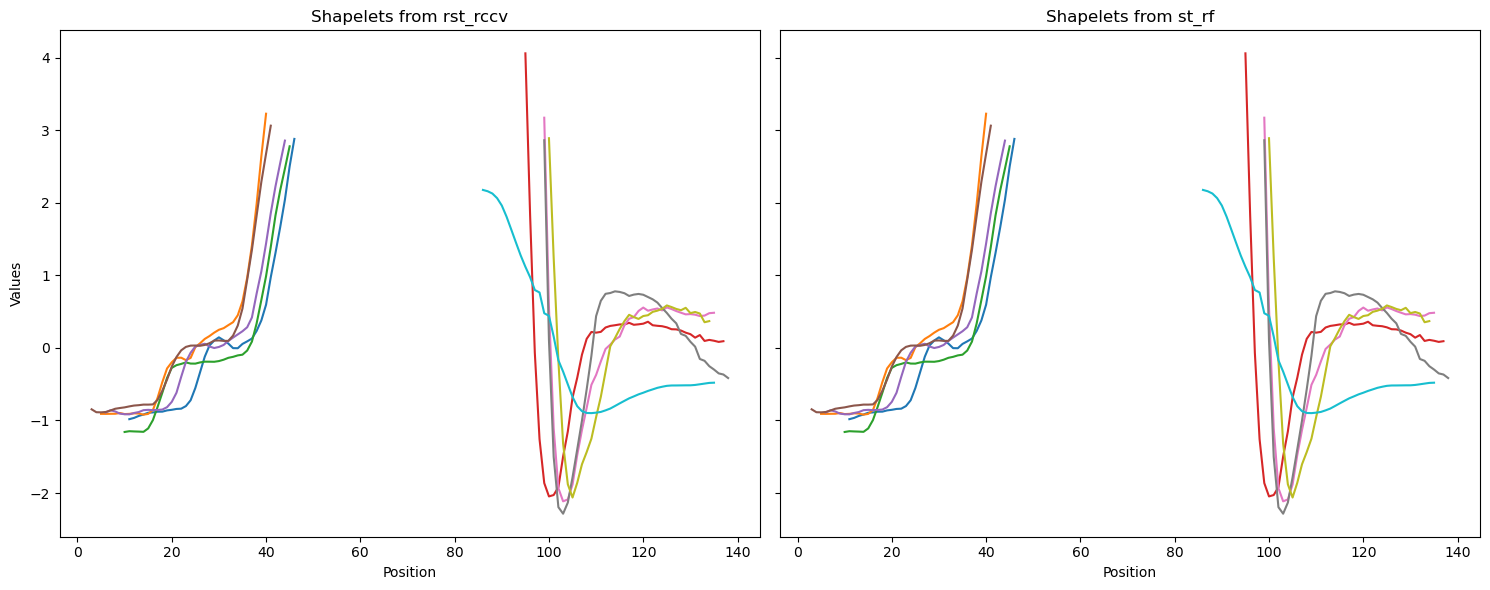

In [9]:
import matplotlib.pyplot as plt

# First set of shapelets (from rst_rccv)
shapelets_rccv = rst_rccv._transformer.shapelets
shapelet_vals_rccv = []
shapelet_pos_rccv = []

for shapelet in shapelets_rccv:
    shapelet_vals_rccv.append(shapelet[6])
    shapelet_pos_rccv.append(shapelet[2])

# Second set of shapelets (from st_rf)
shapelets_rf = rst_rf._transformer.shapelets
shapelet_vals_rf = []
shapelet_pos_rf = []

for shapelet in shapelets_rf:
    shapelet_vals_rf.append(shapelet[6])
    shapelet_pos_rf.append(shapelet[2])

# Create a figure with 2 subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot the first set of shapelets (rst_rccv)
for i in range(len(shapelet_vals_rccv)):
    x_values = [x + shapelet_pos_rccv[i] for x in range(len(shapelet_vals_rccv[i]))]
    axs[0].plot(x_values, shapelet_vals_rccv[i])

axs[0].set_title("Shapelets from rst_rccv")
axs[0].set_xlabel("Position")
axs[0].set_ylabel("Values")

# Plot the second set of shapelets (st_rf)
for i in range(len(shapelet_vals_rf)):
    x_values = [x + shapelet_pos_rf[i] for x in range(len(shapelet_vals_rf[i]))]
    axs[1].plot(x_values, shapelet_vals_rf[i])

axs[1].set_title("Shapelets from st_rf")
axs[1].set_xlabel("Position")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

The above plot is just validating that the same 10 shapelets were generated for both classifiers, now lets see how they rank them in th eimportance at distnguishing each class.

In [10]:
import pandas as pd

from aeon.visualisation import ShapeletClassifierVisualizer

rst_rccv_vis = ShapeletClassifierVisualizer(rst_rccv)
rst_rf_vis = ShapeletClassifierVisualizer(rst_rf)

# Define the lists from the output
rst_rf_vis_index_0 = rst_rf_vis._get_shp_importance(0)[0]
rst_rf_vis_index_1 = rst_rf_vis._get_shp_importance(1)[0]
rst_rccv_vis_index_0 = rst_rccv_vis._get_shp_importance(1)[0]
rst_rccv_vis_index_1 = rst_rccv_vis._get_shp_importance(0)[0]

# Create a dictionary to store the elements at each position in the lists
elements_in_position = {
    "Rank": list(range(10)),
    "Random forest Gun": rst_rf_vis_index_0,
    "Random forest No Gun": rst_rf_vis_index_1,
    "Ridge classifier CV Gun": rst_rccv_vis_index_0,
    "Ridge classifier CV No Gun": rst_rccv_vis_index_1,
}

# Convert the dictionary to a DataFrame
pd.DataFrame(elements_in_position).set_index("Rank")

,Random forest Gun,Random forest No Gun,Ridge classifier CV Gun,Ridge classifier CV No Gun
Rank,,,,
0,0,0,1,2
1,4,4,5,0
2,2,2,4,3
3,3,3,9,8
4,7,7,6,7
5,6,6,7,6
6,1,1,8,9
7,5,5,3,4
8,8,8,0,5


As you can see the different classifiers find the same shapelets to be of different importance. In fact they only partly aggree on ranks 4 and 5.

Two patterns emerge in the importance ranking, the random forest finds the same shapelets equally important for both classes while Ridge CV flips the importance for each class. This makes sense given RF are tree based and use information gain as a quality measure, the most discrimintaive shapelet is the best at distinguishing the two classes so its just as important for both. While the importance for Ridge CV is found using the coefficinets assigned to the features (shapelets), a linear model, assigns positive or negative coefficients to features based on how strongly they correlate with each class. This means that a shapelet contributing positively to one class may contribute negatively to another, resulting in a flip in importance across classes.

Lets look at each classifier's most important shapelet.

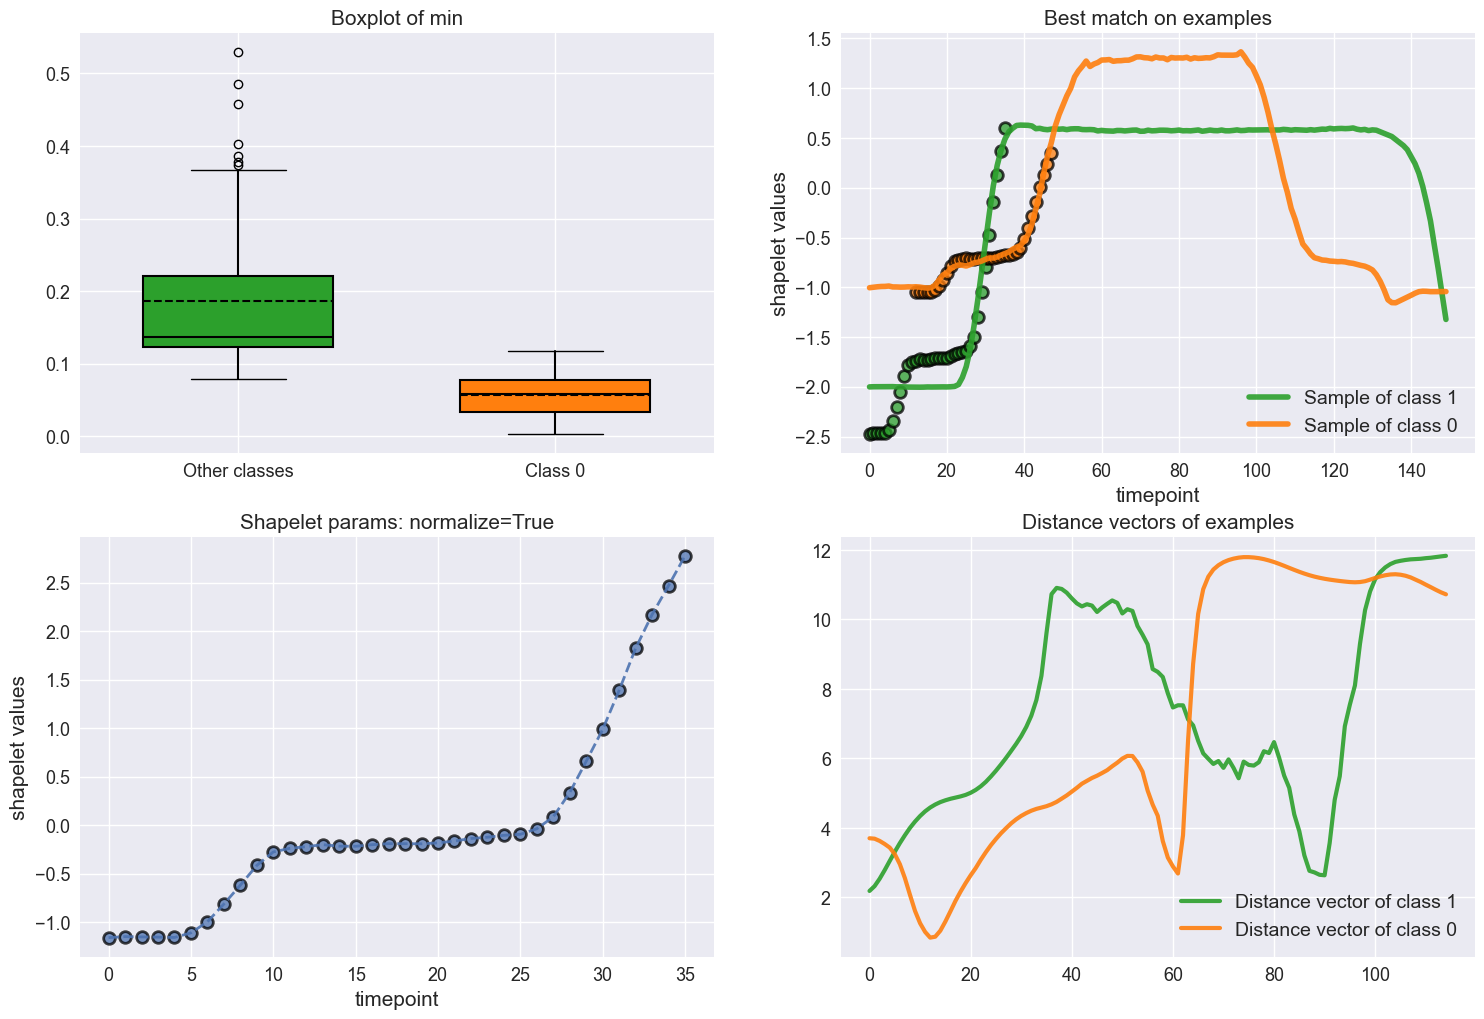

In [11]:
fig = rst_rccv_vis.visualize_shapelets_one_class(  # this is worst for other class
    X_gun_test,
    y_gun_test,
    0,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

Before examing the shapelets lets understanding how they are represented.

- Boxplot of Min (Top Left): The distribution of the minimum distances between the shapelet and each class. As expected, the shapelet fits class 0 more closely than the other.

- Best Match on Examples (Top Right): This graph shows how the shapelet fits a random time series from each class. The shapelet should, and does, align more closely with the time series of class 0.

- Shapelet Params (Bottom Left): This graph displays the shapelet's pattern and length. 

- Distance Vectors of Examples (Bottom Right): This graph offers a comparison of how well the shapelet fits the two time series, from the 'Best Match on Examples' graph, at each point.

If you're wondering why the same shapelet looks different when fit to the orange and green time series that is due to the normalisation parameter, this will become even more obvious in later graphs. The normalisation parameter normalises the distance between the shapelet and the time series enabling scale invariance. This means no matter the amplitude of the pattern it will be noticed, if its present. Think of the two actors who have different heights, if they both shrug their shoulders when holding the real gun the change in height will be different but normalisation generalises the pattern to be found in them both.

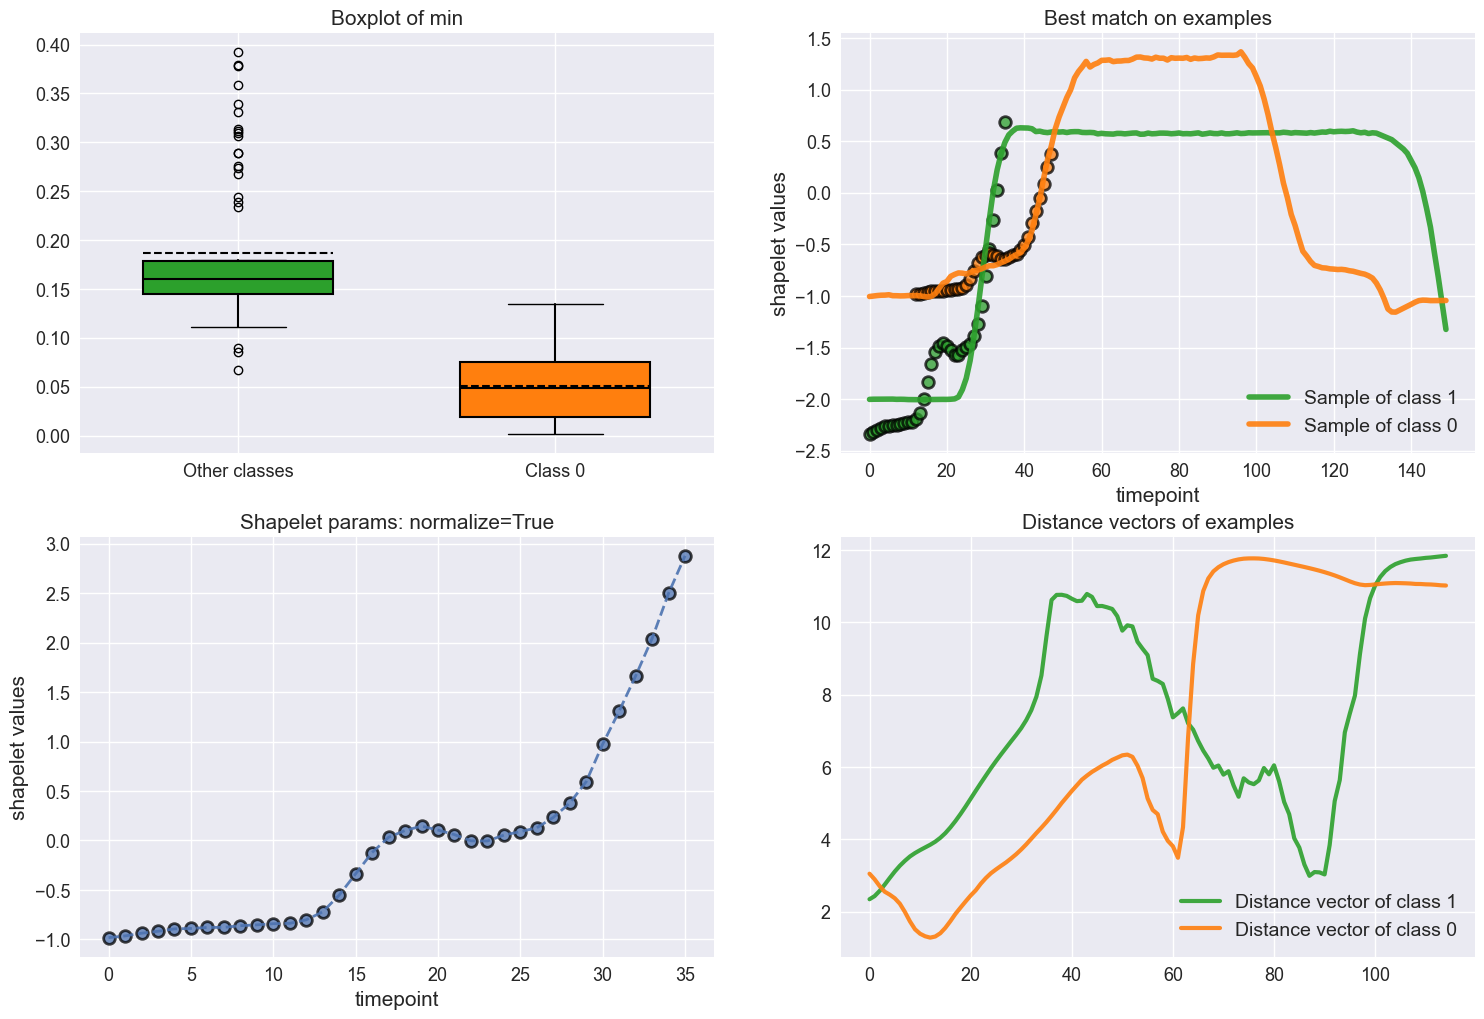

In [12]:
fig = rst_rf_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

|Talk about scale invariance???


Here we learn that the most important shapelet is found during the raise rather than descent. ###This is different to the research

Now i want to plot the worst shapelet for each one for each class

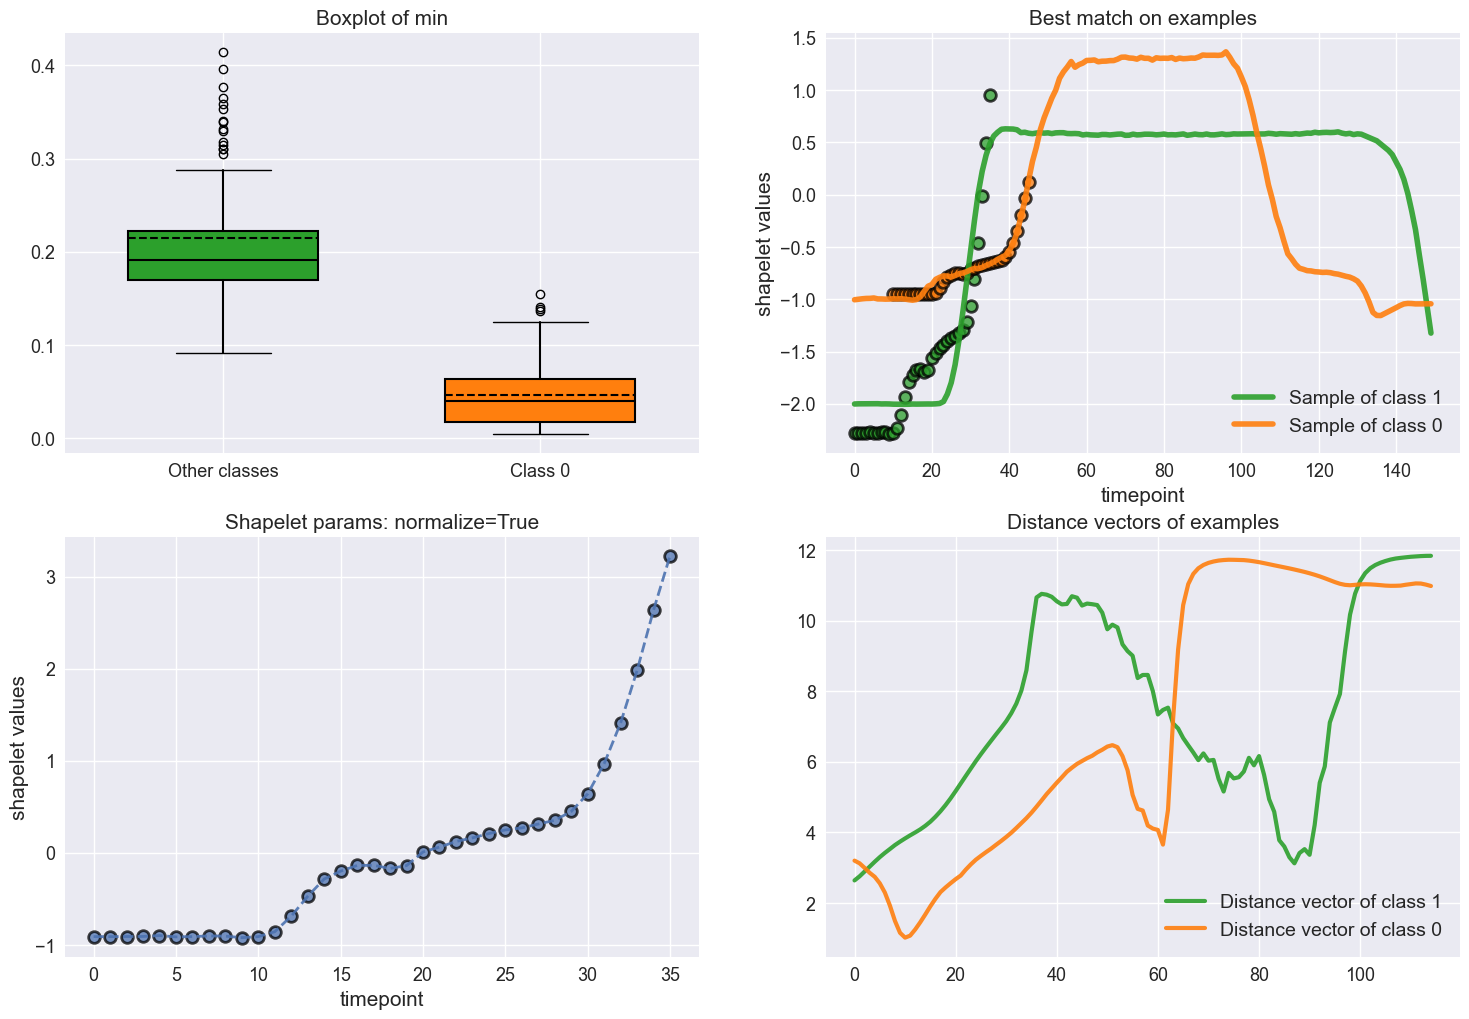

In [13]:
fig = rst_rccv_vis.visualize_shapelets_one_class(  # this is best for other class
    X_gun_test,
    y_gun_test,
    0,
    best=False,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

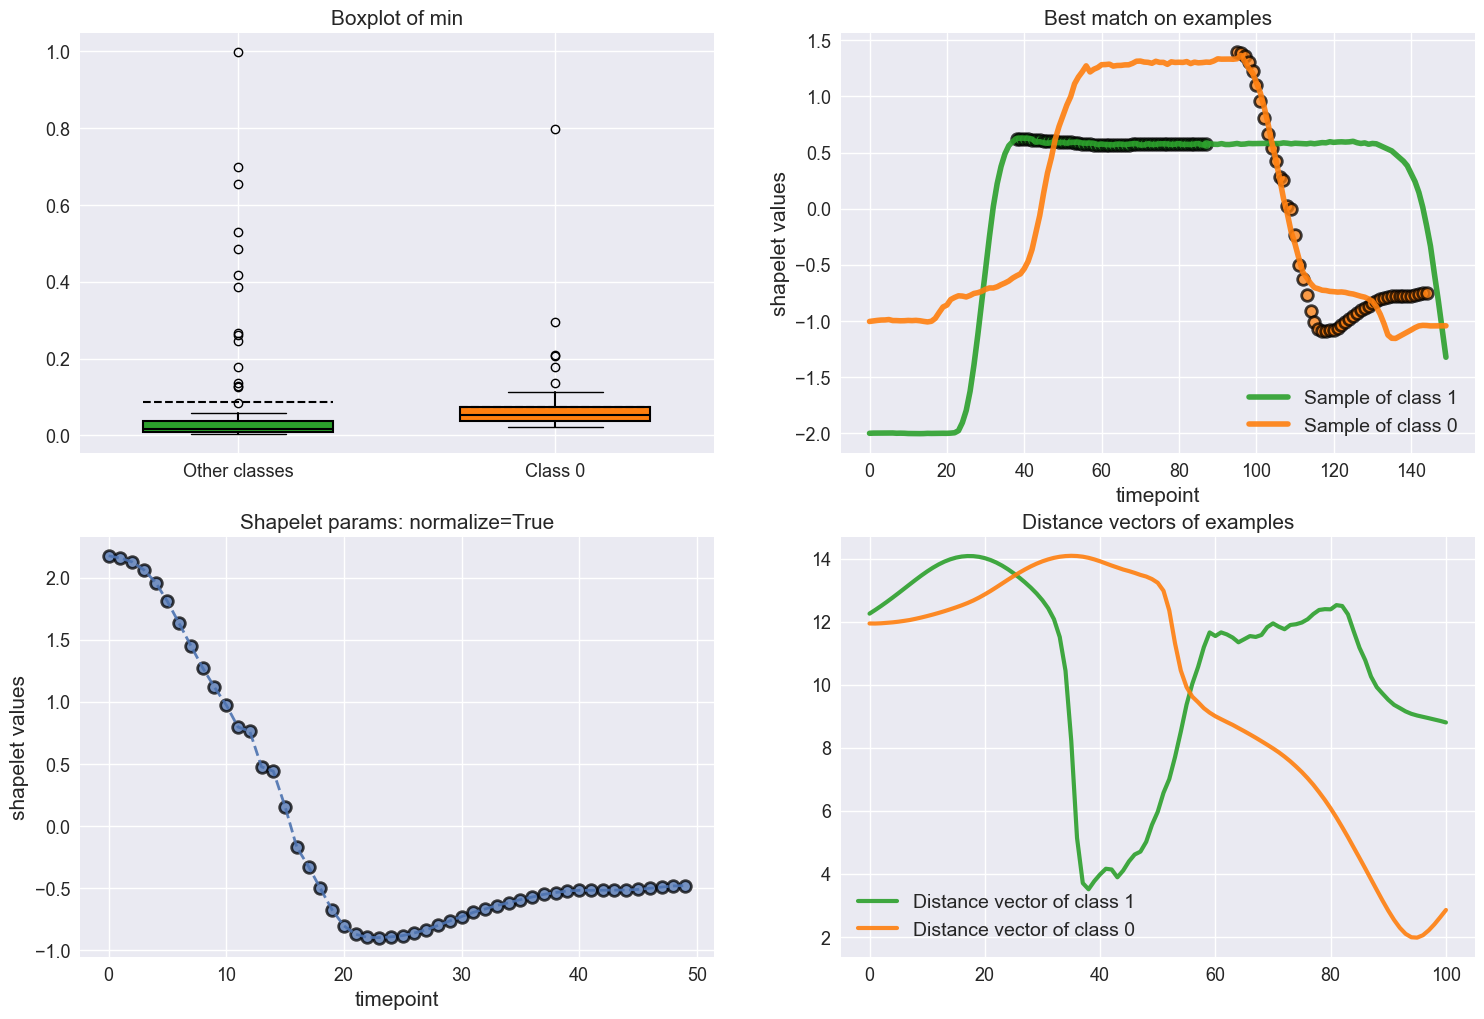

In [14]:
fig = rst_rf_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    best=False,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

worst shapelet isnt the one that is the furtherst from its class remember!!!

#### Random Dilated Shapelet Transform

This paper did not explore the Gunpoint problem, however the default parameters were defined as:

- proportion of z-normalised shapelets = 0.8
- number of shapelets to generate = 10000
- the set of possible lengths of shapelets = [11]
- The percentile boundaries used to sample the occurrence threshold: P1 = 5, P2 = 10

In [15]:
from aeon.transformations.collection.shapelet_based import (
    RandomDilatedShapeletTransform,
)

shapelet_lengths = array = list(range(3, 151))

start_time = time.time()
rdst = RandomDilatedShapeletTransform(
    max_shapelets=10, shapelet_lengths=shapelet_lengths, random_state=99
).fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

pd.DataFrame(rdst.transform(X_gun_test))

Time taken to fit: 44.2428 seconds


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,90.434199,3.0,0.0,17.355638,75.0,7.0,10.386658,0.0,26.0,40.179315,...,21.0,56.148556,40.0,2.0,9.551824,0.0,5.0,52.913176,7.0,8.0
1,135.849066,6.0,0.0,3.686757,71.0,17.0,1.642856,16.0,31.0,84.113754,...,34.0,27.728299,33.0,16.0,80.008337,0.0,0.0,103.219560,5.0,0.0
2,33.562295,12.0,19.0,38.949554,75.0,0.0,31.059927,0.0,26.0,120.235665,...,38.0,114.101873,40.0,0.0,100.936584,0.0,0.0,132.838340,7.0,0.0
3,102.310401,6.0,0.0,16.735445,75.0,6.0,7.344196,6.0,32.0,54.277397,...,28.0,44.031600,40.0,12.0,13.385243,2.0,7.0,67.742900,7.0,8.0
4,128.388239,0.0,0.0,3.359251,72.0,19.0,4.339736,12.0,30.0,70.461800,...,29.0,14.162884,34.0,18.0,62.584215,3.0,0.0,90.738198,7.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,135.355015,18.0,0.0,4.208665,66.0,23.0,2.440272,10.0,25.0,85.008389,...,34.0,26.381014,27.0,20.0,79.696595,2.0,0.0,105.337189,0.0,0.0
146,127.067882,6.0,0.0,8.040580,75.0,12.0,4.457694,18.0,36.0,81.911406,...,36.0,10.108008,40.0,12.0,59.300146,7.0,0.0,99.294487,7.0,0.0
147,129.879600,18.0,0.0,2.949177,75.0,15.0,4.560666,14.0,32.0,71.675794,...,31.0,8.895907,36.0,16.0,62.762211,7.0,0.0,91.516401,7.0,3.0
148,55.464392,1.0,6.0,29.185184,75.0,0.0,25.963341,0.0,16.0,63.351727,...,16.0,87.586437,40.0,0.0,60.177518,8.0,0.0,65.302530,7.0,8.0


Here, we are training a random forest classifier on the transformed data. The purpose is not to evaluate classification performance but to make use of the feature importance provided by the Random Forest to aid in comparing shapelets further on.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV

from aeon.classification.shapelet_based import RDSTClassifier

rdst_rccv = RDSTClassifier(
    estimator=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)),
    max_shapelets=10,
    save_transformed_data=True,
    shapelet_lengths=shapelet_lengths,
    # random_state=99,
).fit(X_gun_train, y_gun_train)

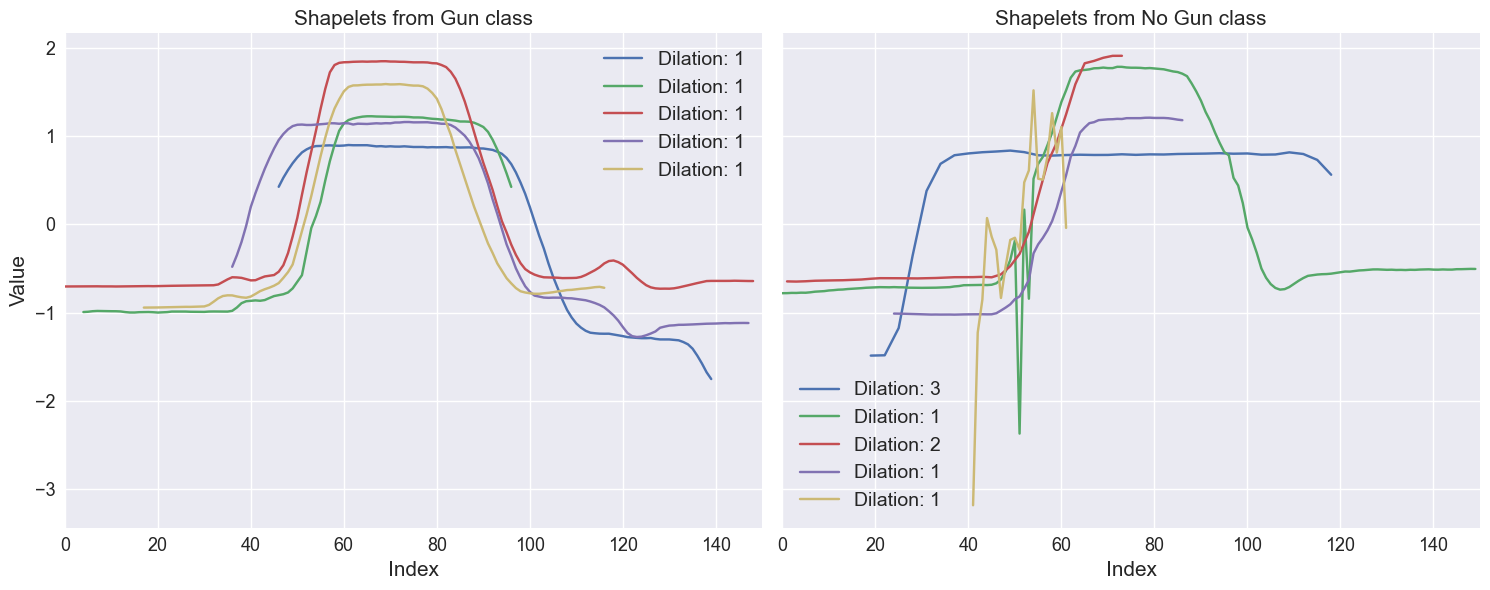

In [17]:
import matplotlib.pyplot as plt

shapelets_rccv = rdst_rccv._transformer.shapelets_
shapelet_vals_rccv = shapelets_rccv[0]
shapelet_pos_rccv = shapelets_rccv[1]
shapelet_dilation = shapelets_rccv[3]
shapelet_classes = shapelets_rccv[8]  # Class labels

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot each shapelet in its respective subplot based on its class
for idx, shapelet in enumerate(shapelet_vals_rccv):
    dilation = shapelet_dilation[idx]
    startpoint = shapelet_pos_rccv[idx]
    x_values = [startpoint + i * dilation for i in range(len(shapelet[0]))]

    if shapelet_classes[idx] == 0:
        axs[0].plot(x_values, shapelet[0], label=f"Dilation: {dilation}")
    else:
        axs[1].plot(x_values, shapelet[0], label=f"Dilation: {dilation}")

# Customize the first subplot for class 0
axs[0].set_title("Shapelets from Gun class")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Value")
axs[0].legend()
axs[0].set_xlim(0, 150)

# Customize the second subplot for class 1
axs[1].set_title("Shapelets from No Gun class")
axs[1].set_xlabel("Index")
axs[1].legend()
axs[1].set_xlim(0, 150)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

As you can see we have very different shapelets extracted with RDST. They look jagged because of the dilation

In [18]:
import pandas as pd

from aeon.visualisation import ShapeletClassifierVisualizer

rdst_rccv_vis = ShapeletClassifierVisualizer(rdst_rccv)

# Define the lists from the output
rdst_rccv_vis_index_0 = (
    pd.Series(rdst_rccv_vis._get_shp_importance(0)[0]).drop_duplicates().to_list()
)
rdst_rccv_vis_index_1 = (
    pd.Series(rdst_rccv_vis._get_shp_importance(1)[0]).drop_duplicates().to_list()
)

# Create a dictionary to store the elements at each position in the lists
elements_in_position = {
    "Rank": list(range(len(rdst_rccv_vis_index_0))),
    "Ridge classivier CV Gun": rdst_rccv_vis_index_0,
    "Ridge classivier CV No Gun": rdst_rccv_vis_index_1,
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(elements_in_position).set_index("Rank")
df

,Ridge classivier CV Gun,Ridge classivier CV No Gun
Rank,,
0,0,2
1,9,4
2,5,6
3,7,3
4,1,8
5,8,1
6,3,7
7,6,5
8,4,9


Remember we said feature importance is calc by for linear clfs

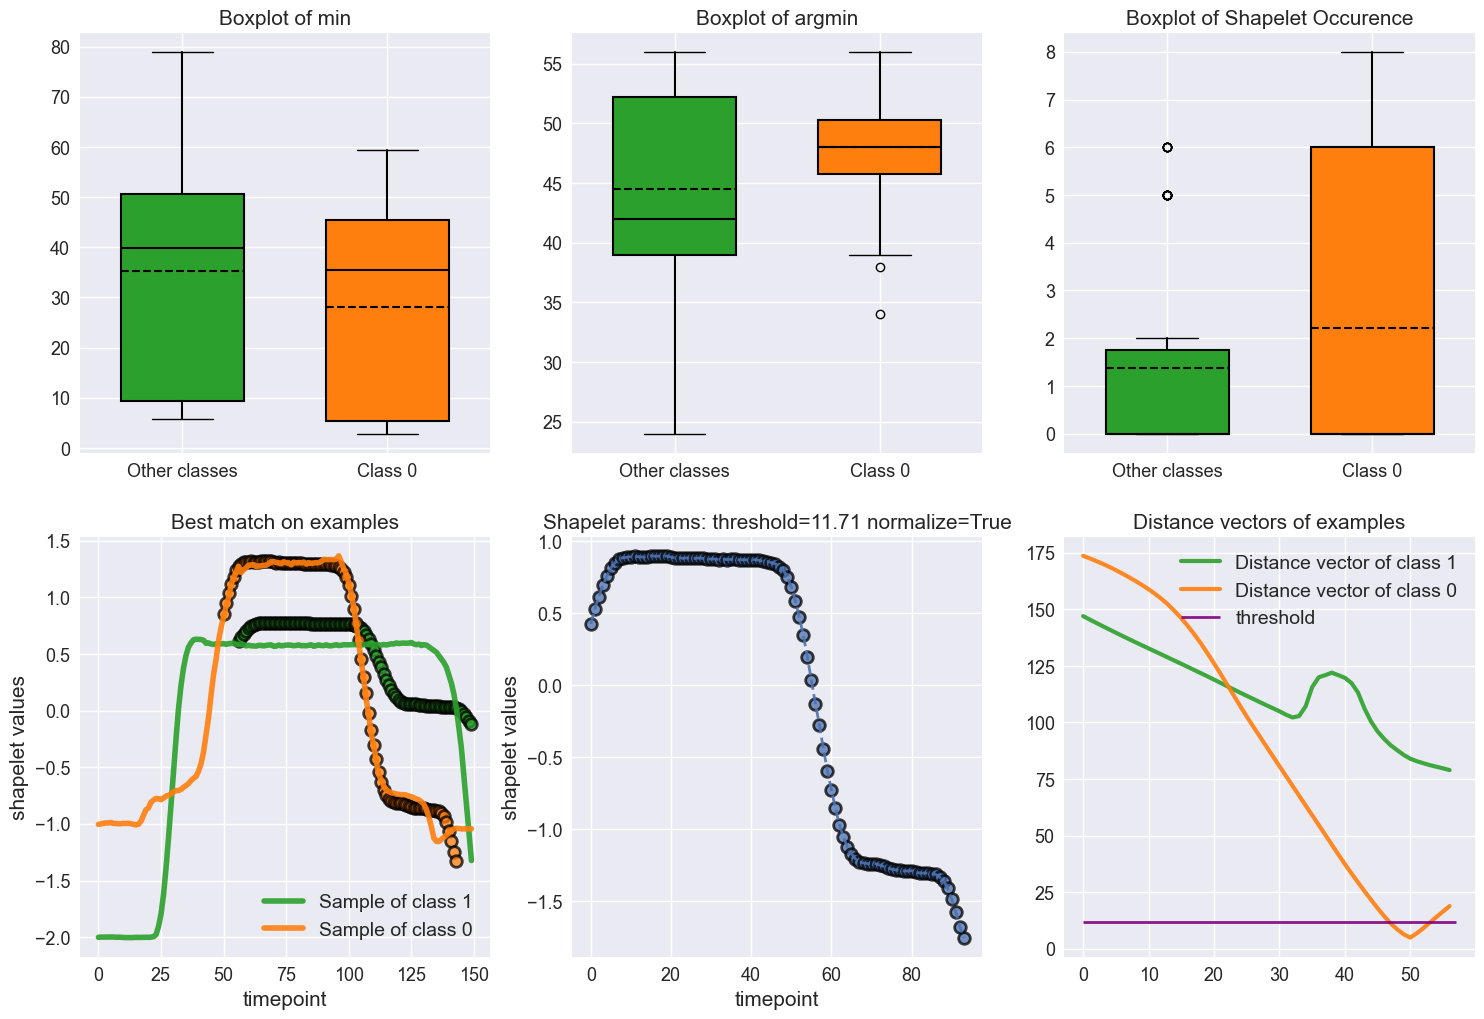

In [19]:
fig = rdst_rccv_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 3},
)

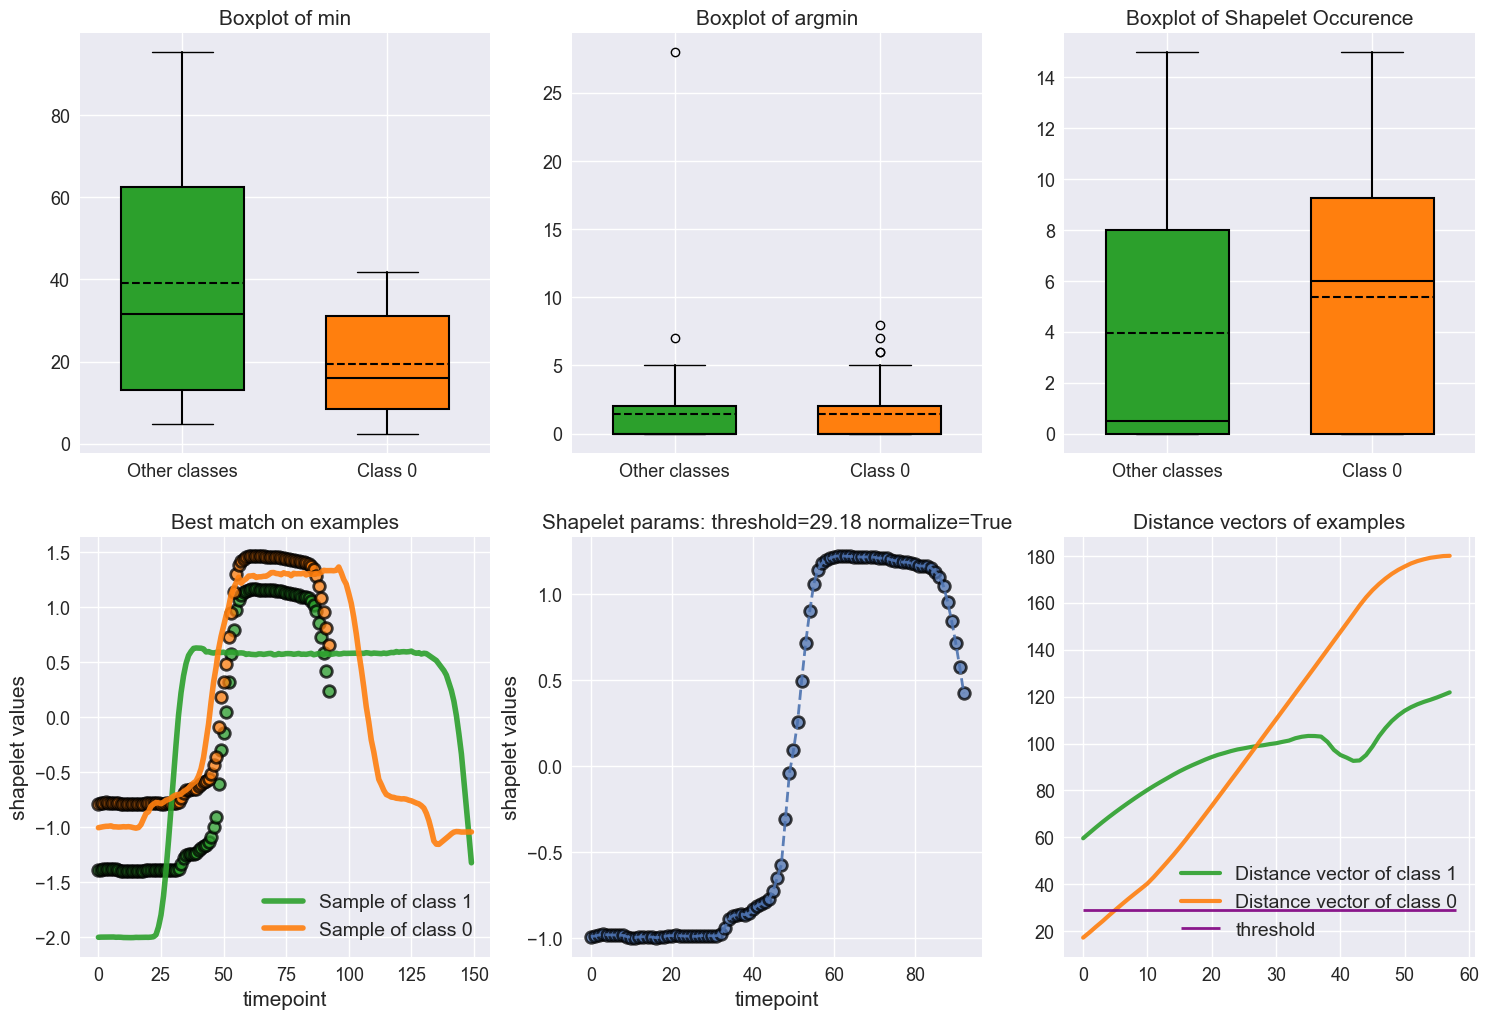

In [20]:
fig = rdst_rccv_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    best=False,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 3},
)

This is very interesting, the best shapelet from class 0 is the worst for 1 and vice versa.

#### Scalable and Accurate Subsequence Transform

In [21]:
import time

from aeon.transformations.collection.shapelet_based import SAST

start_time = time.time()
sast = SAST().fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

pd.DataFrame(sast.transform(X_gun_test))

Time taken to fit: 0.0941 seconds


,0,1,2,3,4,5,6,7,8,9,...,22040,22041,22042,22043,22044,22045,22046,22047,22048,22049
0,0.000171,4.986490e-04,4.941773e-05,0.003790,0.003984,1.358101e-03,0.000091,0.011984,0.001678,0.000453,...,68.113960,68.239067,68.395584,68.707420,68.727066,68.731049,68.471817,68.628197,69.060715,69.071503
1,0.000478,7.879862e-04,1.244837e-04,0.000324,0.004661,8.815980e-07,0.000266,0.077515,0.210764,0.000005,...,3.741453,4.717078,7.082222,13.950408,9.316195,6.015170,4.740557,7.114467,14.007667,9.354983
2,0.000028,4.588609e-07,1.243480e-04,0.000069,0.000052,5.489589e-05,0.000364,0.000010,0.019792,0.001501,...,178.591568,178.548279,178.527985,191.134140,190.962784,190.771957,179.022446,178.976929,191.583649,191.394150
3,0.000537,2.898154e-03,2.903996e-05,0.002122,0.000720,3.227800e-04,0.009210,0.002260,0.003395,0.000941,...,48.422966,49.576443,51.096371,46.634243,46.636833,46.927536,49.746819,51.268986,46.875660,47.170082
4,0.000226,9.093417e-05,3.087129e-06,0.001234,0.008253,7.873017e-06,0.000305,0.051689,0.009160,0.001886,...,1.527273,1.527508,1.527070,21.461655,15.568135,10.701016,1.533915,1.533609,21.543852,15.626773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.001537,6.456215e-05,5.126509e-08,0.003186,0.000364,4.369108e-05,0.009565,0.000092,0.001111,0.000202,...,13.262580,8.550586,5.271501,62.376740,51.786152,41.978596,13.328352,8.596322,62.653515,52.017059
146,0.005395,9.308200e-04,2.517944e-04,0.003354,0.000054,5.475468e-04,0.000098,0.004431,0.001685,0.000606,...,22.040052,29.515371,37.882580,3.965507,4.338061,6.069705,29.610785,38.004768,4.365573,6.104211
147,0.000093,5.412043e-03,6.575928e-07,0.002401,0.002646,4.501871e-05,0.041823,0.001280,0.018250,0.004597,...,3.975783,6.155934,9.767071,7.013851,4.425121,3.243526,6.176665,9.799243,7.043352,4.444687
148,0.018143,6.462939e-04,1.025185e-06,0.002684,0.006668,1.170273e-03,0.000127,0.000486,0.010998,0.000250,...,117.613472,117.268158,117.045059,129.962738,130.487579,130.926315,117.975418,117.627846,130.896133,131.340866


SAST [1]_ first randomly selects 1 time series from each class (they are called
    reference time series). Then SAST generates all the subsequences of the
    specified lengths from these reference time series. These subsequences
    are then used to transform a time series dataset, replacing each time
    series by the vector of its distance to each subsequence.

Unlike the previous two SAST doesn't select these so called best subseries, so before we plot we need to chose 10 to visualise.

Here, we are training a random forest classifier on the transformed data. The purpose is not to evaluate classification performance but to make use of the feature importance provided by the Random Forest to aid in comparing shapelets further on.

In [22]:
from sklearn.linear_model import RidgeClassifierCV

from aeon.classification.shapelet_based import SASTClassifier

sast_rccv = SASTClassifier(
    classifier=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)),
    seed=0,
    nb_inst_per_class=10,
).fit(X_gun_train, y_gun_train)

In the case where subsampling completely
removes one actor from the training data, the performance on the test set, where the two
actors are present, could be reduced.

In [23]:
from operator import itemgetter

feature_importance = abs(sast_rccv._pipeline[-1].coef_[0])

subseries = sast_rccv._transformer._kernel_orig
norm_subseries = sast_rccv._transformer._kernels
start_pos = sast_rccv._transformer._start_positions
classes = sast_rccv._transformer._classes
time_series_indexes = sast_rccv._transformer._source_series
# Combine shapelets with their feature importance, start positions, and class info
features = zip(
    subseries,
    norm_subseries,
    feature_importance,
    start_pos,
    classes,
    time_series_indexes,
)

# Sort features by importance (descending order)
sorted_features = sorted(features, key=itemgetter(2), reverse=True)

# Extract sorted shapelets, start positions, and class info
subseries = [feature[0] for feature in sorted_features]
norm_subseries = [feature[1] for feature in sorted_features]
start_positions = [feature[3] for feature in sorted_features]
shapelet_classes = [feature[4] for feature in sorted_features]
time_series_indices = [feature[5] for feature in sorted_features]
shapelet_lengths = [len(feature[0]) for feature in sorted_features]

num_shapelets = 10
# Get the top 10 shapelets with their start positions and class information
top_subseries = [
    (subseries, norm_subseries, start_pos, cls)
    for subseries, norm_subseries, start_pos, cls in zip(
        subseries, norm_subseries, start_positions, shapelet_classes
    )
]
shapelets = top_subseries[:num_shapelets]

In [24]:
np.unique(time_series_indices)

array([ 3,  6,  8, 14, 18, 19, 21, 22, 23, 25, 26, 27, 30, 31, 37, 42, 44,
       45, 46, 48], dtype=int64)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


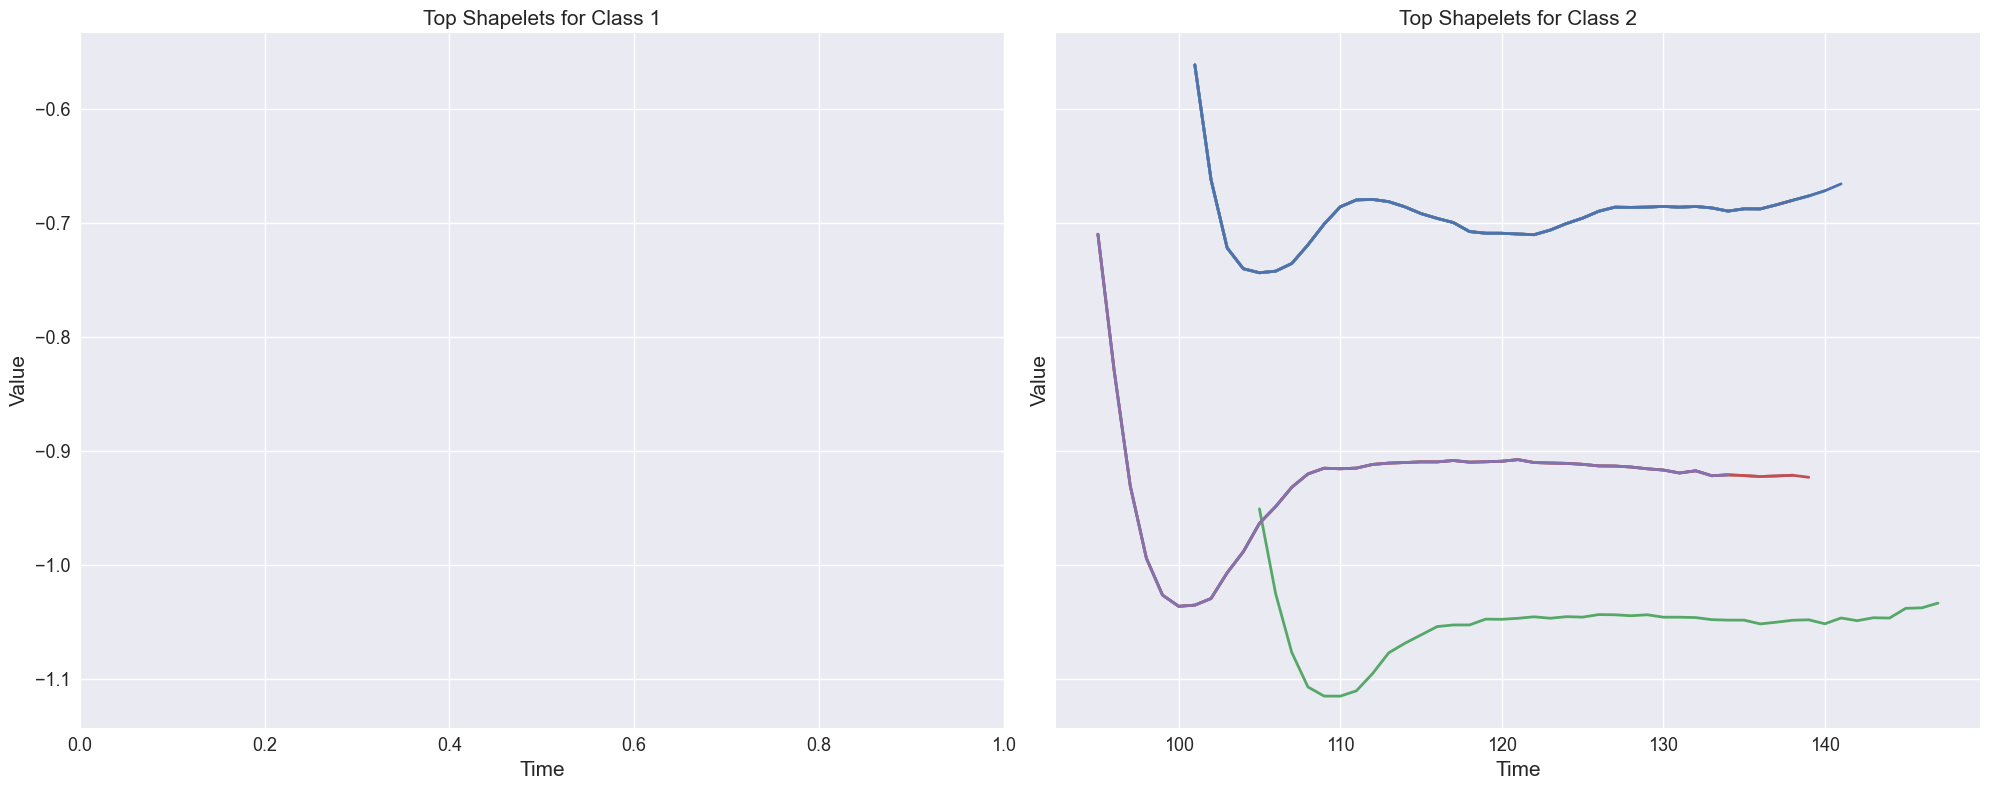

In [25]:
import matplotlib.pyplot as plt

# Separate the shapelets by class
class_1_shapelets = [
    (shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "1"
]
class_2_shapelets = [
    (shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "2"
]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot shapelets for Class 1
for i, (shapelet, start_pos) in enumerate(class_1_shapelets, start=1):
    axes[0].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 1 Shapelet {i}",
        linewidth=2,
    )
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].set_title("Top Shapelets for Class 1")
axes[0].legend()
axes[0].grid(True)

# Plot shapelets for Class 2
for i, (shapelet, start_pos) in enumerate(class_2_shapelets, start=1):
    axes[1].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 2 Shapelet {i}",
        linewidth=2,
    )
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
axes[1].set_title("Top Shapelets for Class 2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


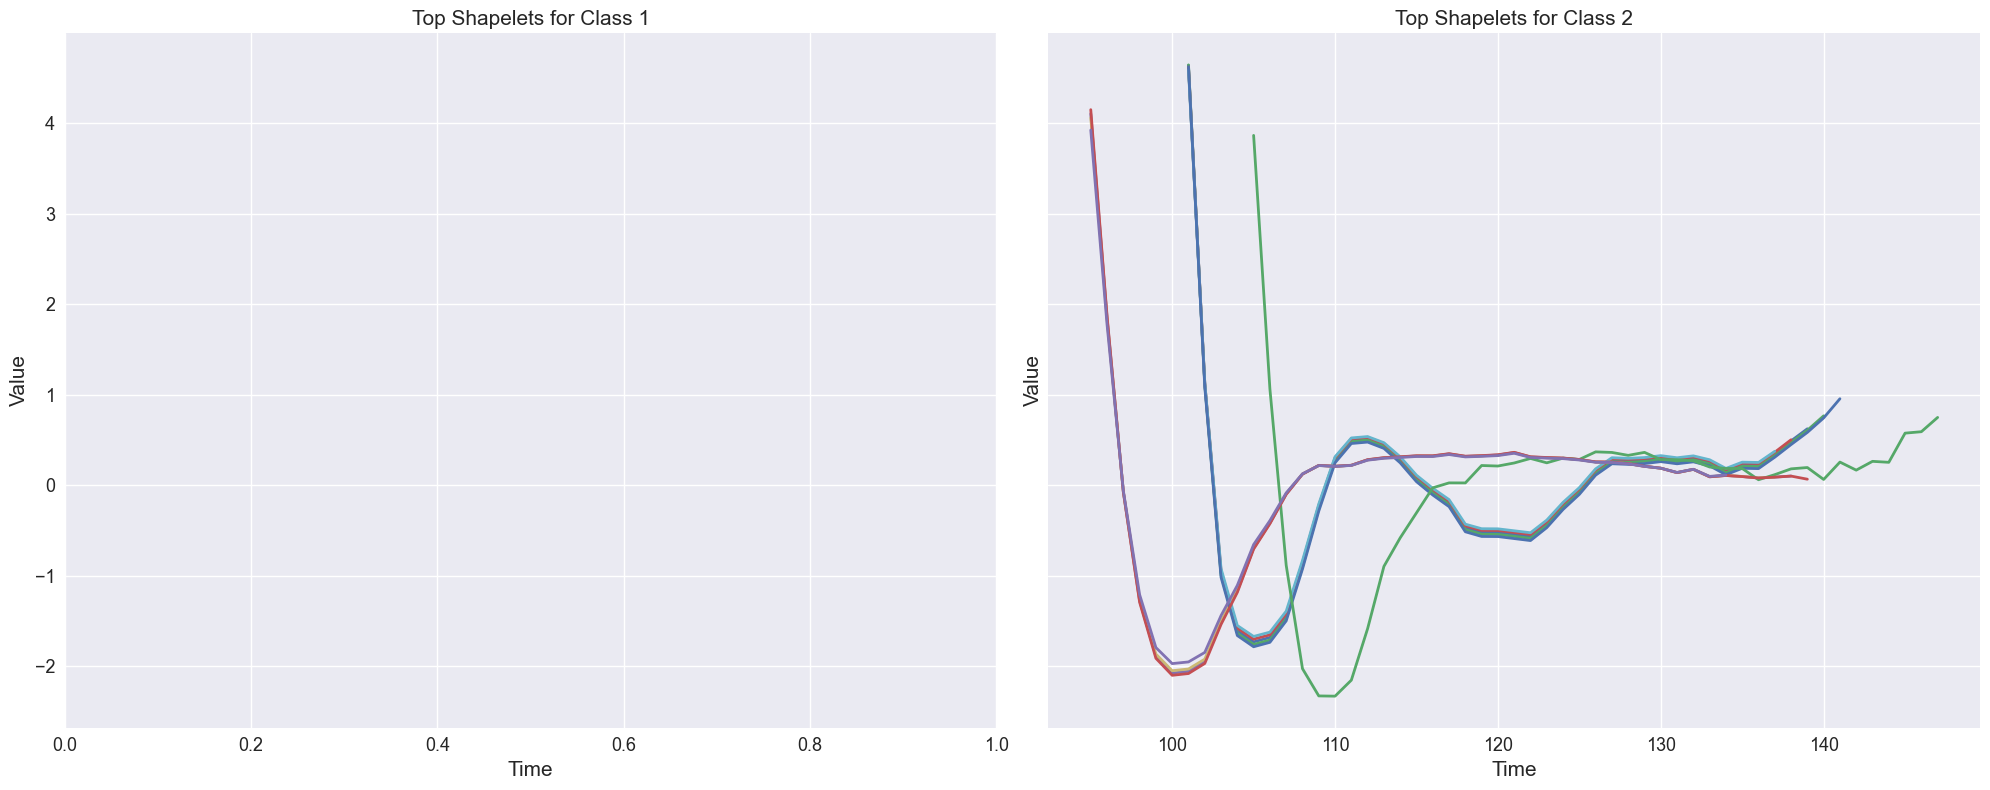

In [26]:
import matplotlib.pyplot as plt

# Separate the shapelets by class
class_1_shapelets = [
    (norm_shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "1"
]
class_2_shapelets = [
    (norm_shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "2"
]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot shapelets for Class 1
for i, (shapelet, start_pos) in enumerate(class_1_shapelets, start=1):
    axes[0].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 1 Shapelet {i}",
        linewidth=2,
    )
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].set_title("Top Shapelets for Class 1")
axes[0].legend()
axes[0].grid(True)

# Plot shapelets for Class 2
for i, (shapelet, start_pos) in enumerate(class_2_shapelets, start=1):
    axes[1].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 2 Shapelet {i}",
        linewidth=2,
    )
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
axes[1].set_title("Top Shapelets for Class 2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

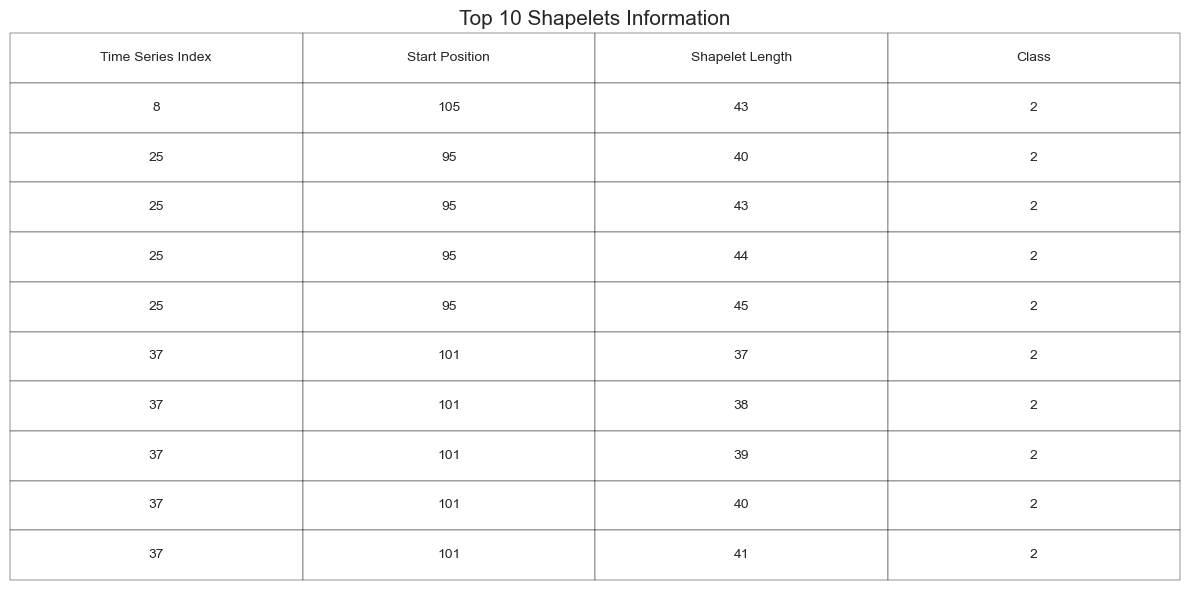

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for the top 10 shapelets
data = {
    "Time Series Index": time_series_indices[:num_shapelets],
    "Start Position": start_positions[:num_shapelets],
    "Shapelet Length": shapelet_lengths[:num_shapelets],
    "Class": shapelet_classes[:num_shapelets],  # New column for shapelet classes
}
df = pd.DataFrame(data)

# Define the priority order for sorting
priority_order = ["Time Series Index", "Start Position", "Shapelet Length", "Class"]

# Sort the DataFrame by the priority columns
df_sorted = df.sort_values(by=priority_order, ascending=True)

# Plot the table
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
ax.axis("off")  # Hide the axis

# Create the table
table = ax.table(
    cellText=df_sorted.values,
    colLabels=df_sorted.columns,
    cellLoc="center",
    loc="center",
    bbox=[0, 0, 1, 1],
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(df_sorted.columns)

plt.title("Top 10 Shapelets Information")
plt.tight_layout()
plt.show()

Here we learn that the 10 best shapelets from SAST are all from class two, and all come from the first time series input at around the same point with a roughly similar length. This tells us, given how similar they all are in pos & length, that this problem only has one particularly discriminative pattern between the two classes. The two plots show the importance of scale & phase invariance in the shapelets, we can see that they both share the pattern just at different heights.

RDST uses the shapelet pos as a feature which is why it needs to search all time series.

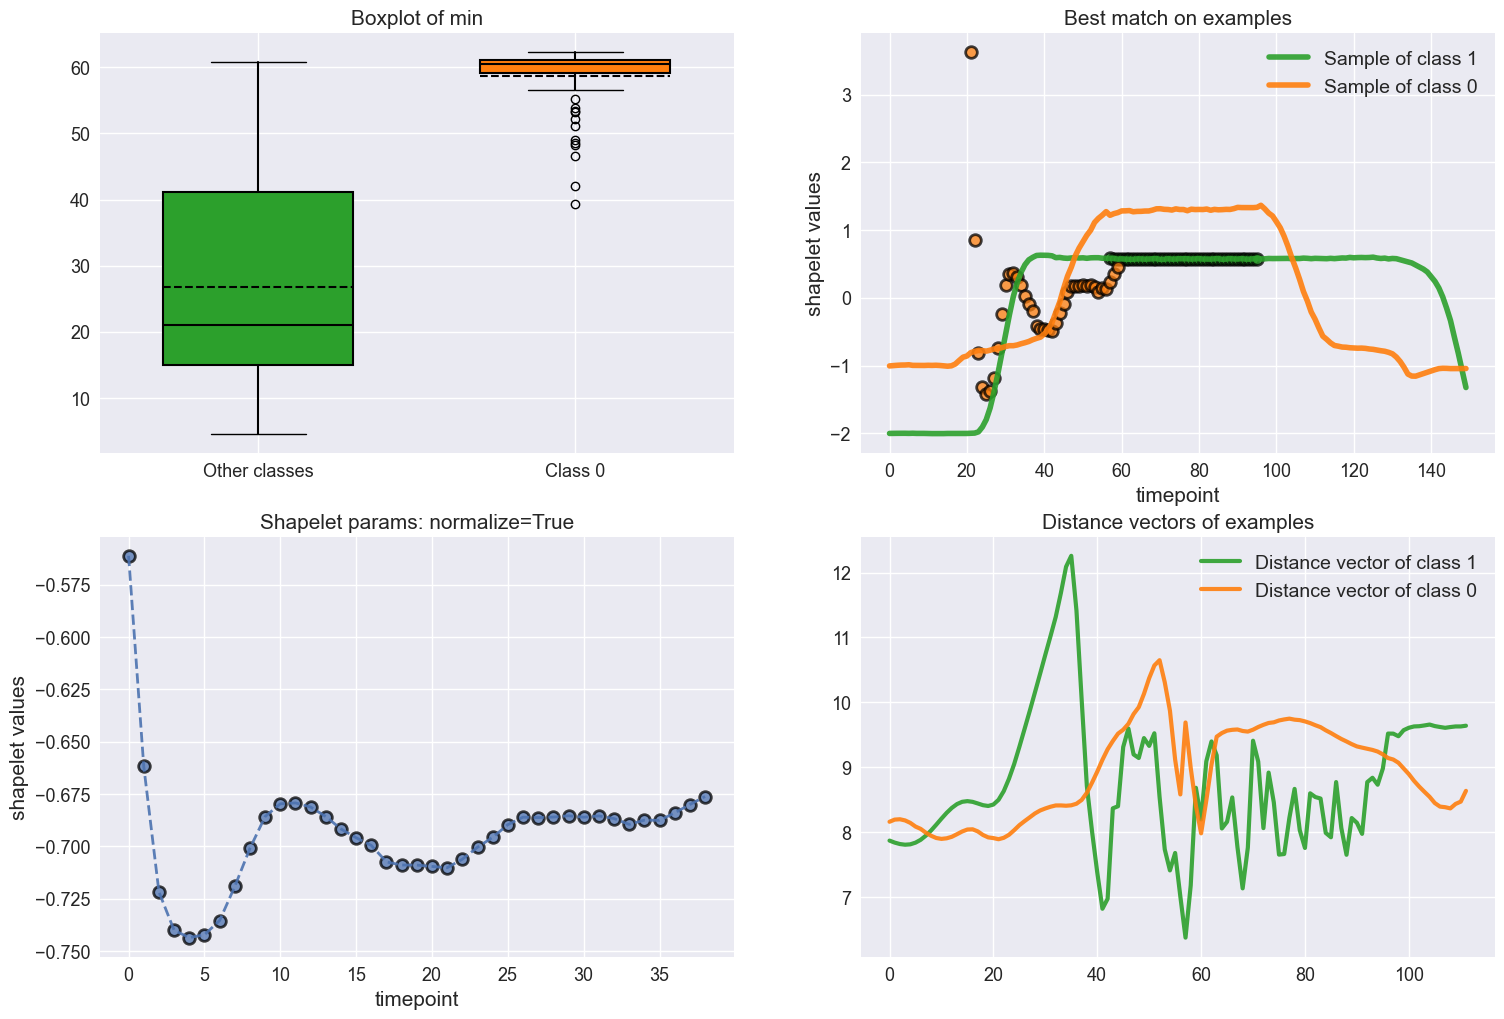

In [28]:
sast_rccv_vis = ShapeletClassifierVisualizer(sast_rccv)

fig = sast_rccv_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

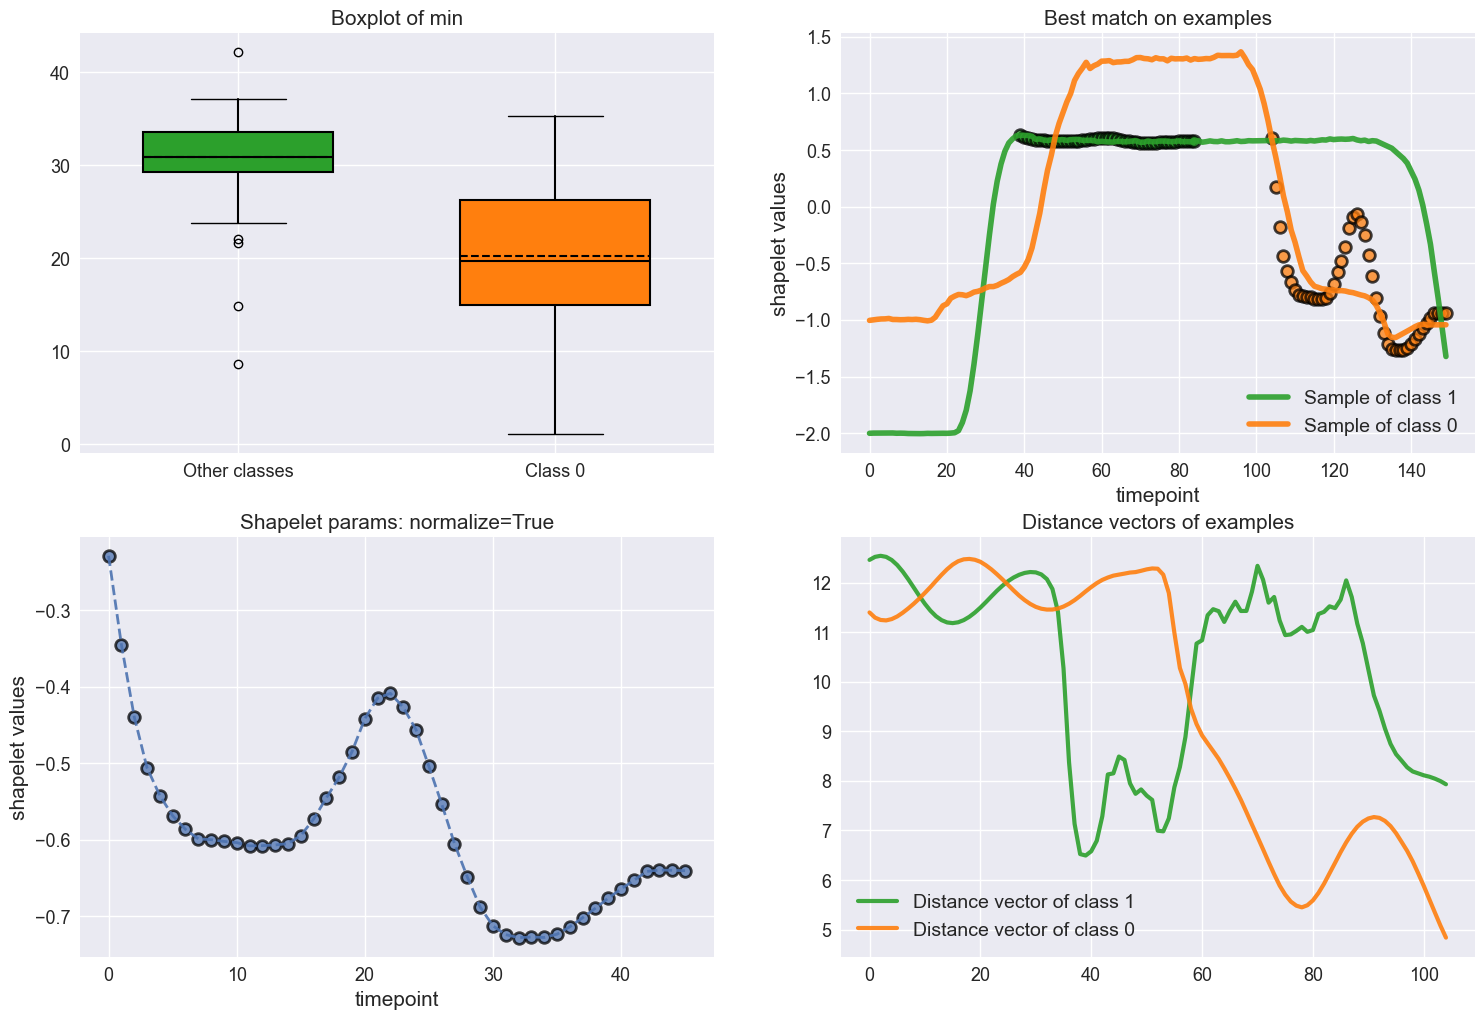

In [29]:
fig = sast_rccv_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    best=False,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

In [30]:
# Filter shapelets by class
best_class_one_shp = [
    (shapelet, start_pos, index)
    for index, (shapelet, start_pos, cls) in enumerate(
        zip(top_subseries, start_positions, shapelet_classes)
    )
    if cls == "1"
][0]

print("Best class one shapelet is ranked", best_class_one_shp[2])

Best class one shapelet is ranked 101


#### Random and Scalable Subsequence Transform

In [31]:
import time

from aeon.transformations.collection.shapelet_based import RSAST

start_time = time.time()
rsast = RSAST().fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

pd.DataFrame(rsast.transform(X_gun_test))

Time taken to fit: 1.0583 seconds


,0,1,2,3,4,5,6,7,8,9,...,4210,4211,4212,4213,4214,4215,4216,4217,4218,4219
0,3.749516e-05,5.093659e-06,1.110515e-06,0.003477,7.644590e-04,9.330698e-05,0.000191,0.000865,2.871099e-04,0.000388,...,1.153160,2.837650,2.183915,11.261748,2.361830,0.728245,1.005454,12.107221,0.629476,0.685118
1,9.506386e-05,4.046886e-06,4.713412e-08,0.000312,1.029269e-06,8.297804e-04,0.000169,0.020755,2.331805e-06,0.003505,...,0.381862,0.454294,52.128624,31.368328,0.415665,0.426376,46.153988,31.003551,12.803461,39.635418
2,1.178719e-04,1.788812e-05,2.600623e-06,0.000015,4.423053e-08,3.482040e-04,0.000387,0.001511,1.128725e-05,0.000387,...,44.872021,25.620186,0.364831,12.162356,32.049564,49.961582,1.923206,16.144905,0.145690,6.247106
3,2.204870e-07,2.442602e-08,1.059196e-04,0.000045,7.299993e-06,2.601423e-03,0.000022,0.001727,3.208035e-05,0.001777,...,1.277552,1.710394,5.984701,11.848843,1.518140,1.166533,2.499262,12.516363,0.749729,1.200734
4,3.706450e-05,5.924356e-05,7.327586e-07,0.000046,1.266268e-04,2.952679e-03,0.000353,0.081162,3.004341e-07,0.004753,...,0.814842,1.103699,44.606373,29.175131,0.974976,0.751934,37.933395,30.537428,6.143292,31.112848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2.936425e-05,1.660434e-05,2.807054e-08,0.005124,1.153889e-04,1.437153e-04,0.002302,0.030005,1.382329e-09,0.006636,...,0.780954,0.954820,50.199558,32.167892,0.863964,0.768729,43.810173,32.409214,10.899153,37.051746
146,4.566810e-06,7.344680e-07,1.094936e-07,0.000006,5.185969e-05,2.023251e-04,0.000181,0.005255,3.206267e-04,0.003505,...,0.726402,1.069467,39.527599,26.558241,0.947984,0.629222,32.361500,28.700386,3.829495,25.531557
147,1.532444e-04,1.200892e-05,4.171098e-04,0.000407,4.817480e-04,3.330089e-07,0.001005,0.008249,1.066230e-03,0.001203,...,0.555370,0.667050,34.938164,25.495081,0.610287,0.546882,27.390520,27.623270,2.980129,20.835964
148,2.297661e-04,8.064431e-06,2.584839e-04,0.000011,7.468133e-05,4.669267e-06,0.000864,0.003375,3.742872e-04,0.000938,...,5.523889,29.318153,0.976511,11.485907,19.353251,2.051295,0.392992,13.191096,0.153577,0.325407


In [49]:
from sklearn.linear_model import RidgeClassifierCV

from aeon.classification.shapelet_based import RSASTClassifier

rsast_rccv = RSASTClassifier(
    classifier=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)), seed=0
).fit(X_gun_train, y_gun_train)

In [33]:
from operator import itemgetter

feature_importance = abs(rsast_rccv._pipeline[-1].coef_[0])

subseries = rsast_rccv._transformer._kernel_orig
norm_subseries = rsast_rccv._transformer._kernels
start_pos = rsast_rccv._transformer._start_positions
classes = rsast_rccv._transformer._classes
time_series_indexes = rsast_rccv._transformer._source_series
# Combine shapelets with their feature importance, start positions, and class info
features = zip(
    subseries,
    norm_subseries,
    feature_importance,
    start_pos,
    classes,
    time_series_indexes,
)

# Sort features by importance (descending order)
sorted_features = sorted(features, key=itemgetter(2), reverse=True)

# Extract sorted shapelets, start positions, and class info
subseries = [feature[0] for feature in sorted_features]
norm_subseries = [feature[1] for feature in sorted_features]
start_positions = [feature[3] for feature in sorted_features]
shapelet_classes = [feature[4] for feature in sorted_features]
time_series_indices = [feature[5] for feature in sorted_features]
shapelet_lengths = [len(feature[0]) for feature in sorted_features]

num_shapelets = 10
# Get the top 10 shapelets with their start positions and class information
top_subseries = [
    (subseries, norm_subseries, start_pos, cls)
    for subseries, norm_subseries, start_pos, cls in zip(
        subseries, norm_subseries, start_positions, shapelet_classes
    )
]
shapelets = top_subseries[:num_shapelets]

In [34]:
np.unique(time_series_indices)

array([ 0,  1,  3,  5,  7, 16, 18, 21, 22, 26, 27, 30, 34, 36, 38, 39, 42,
       46, 48, 49], dtype=int64)

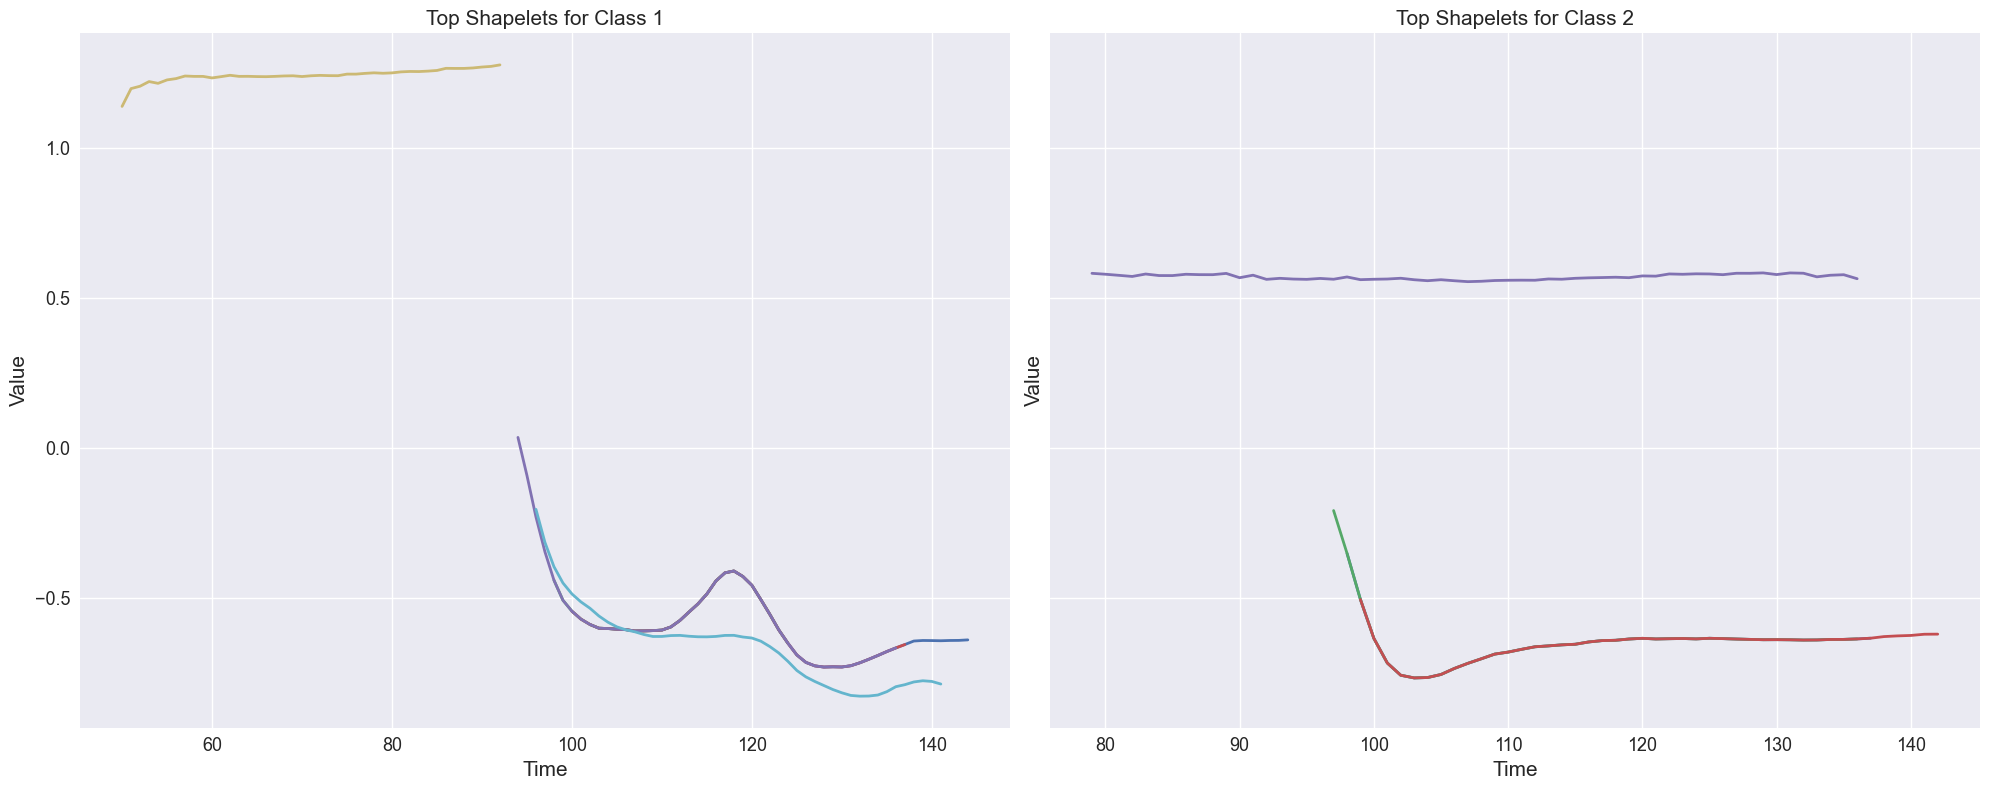

In [35]:
import matplotlib.pyplot as plt

# Separate the shapelets by class
class_1_shapelets = [
    (shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "1"
]
class_2_shapelets = [
    (shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "2"
]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot shapelets for Class 1
for i, (shapelet, start_pos) in enumerate(class_1_shapelets, start=1):
    axes[0].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 1 Shapelet {i}",
        linewidth=2,
    )
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].set_title("Top Shapelets for Class 1")
axes[0].grid(True)

# Plot shapelets for Class 2
for i, (shapelet, start_pos) in enumerate(class_2_shapelets, start=1):
    axes[1].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 2 Shapelet {i}",
        linewidth=2,
    )
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
axes[1].set_title("Top Shapelets for Class 2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

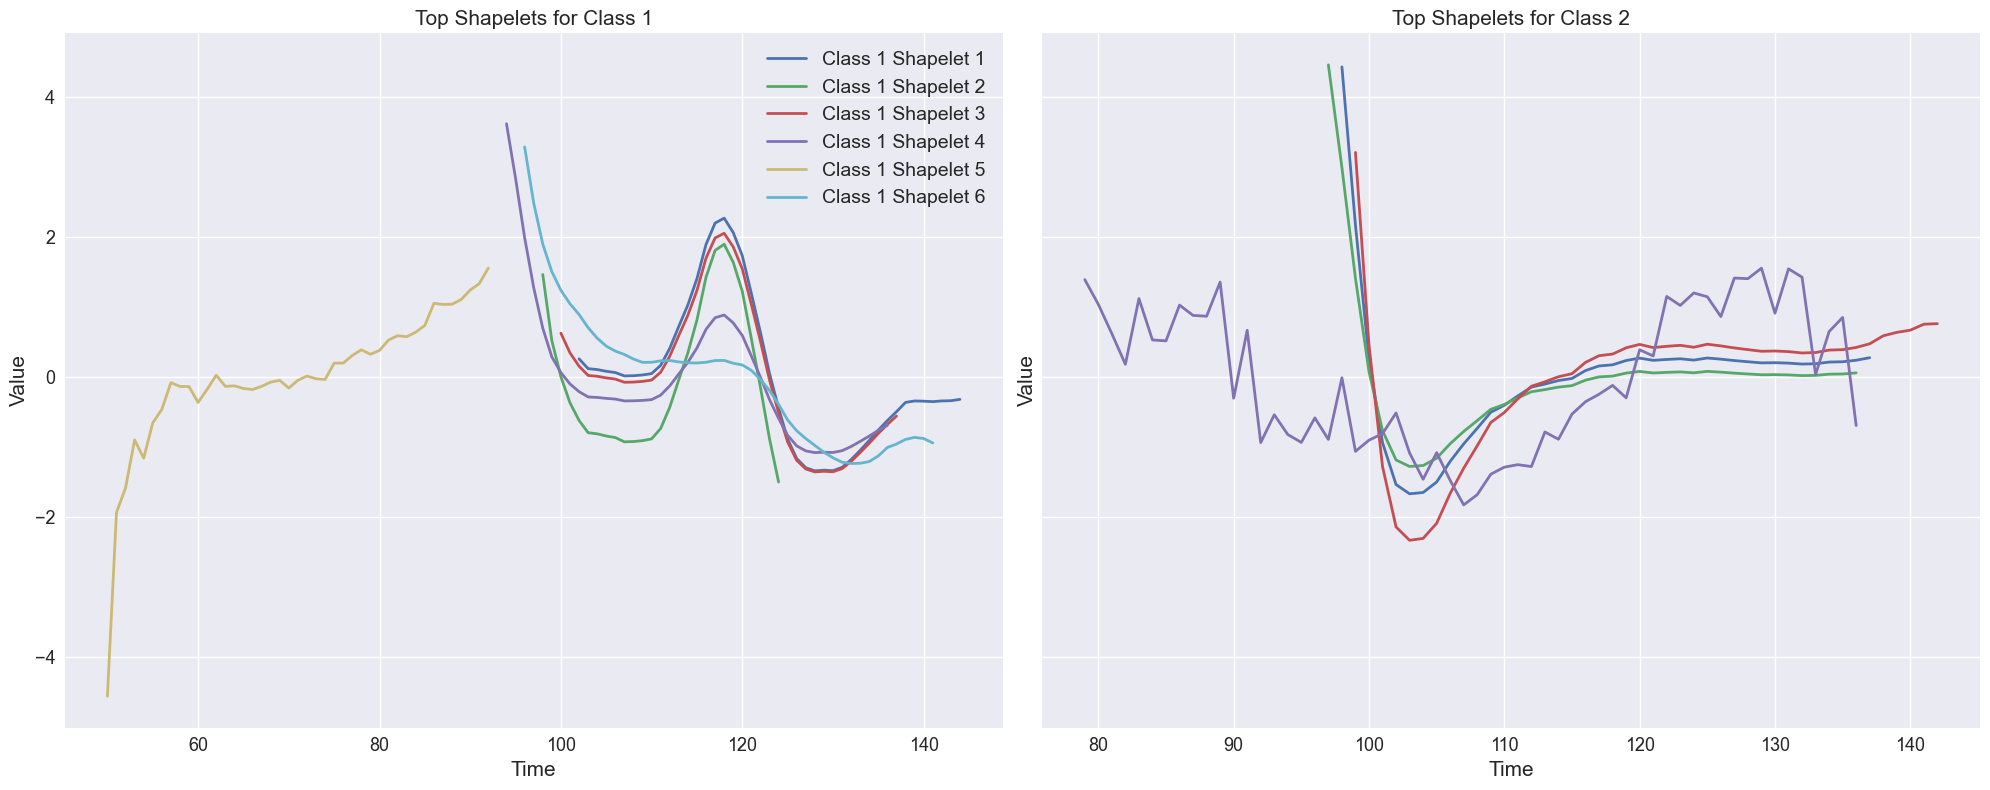

In [36]:
import matplotlib.pyplot as plt

# Separate the shapelets by class
class_1_shapelets = [
    (norm_shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "1"
]
class_2_shapelets = [
    (norm_shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "2"
]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot shapelets for Class 1
for i, (shapelet, start_pos) in enumerate(class_1_shapelets, start=1):
    axes[0].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 1 Shapelet {i}",
        linewidth=2,
    )
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].set_title("Top Shapelets for Class 1")
axes[0].grid(True)

# Plot shapelets for Class 2
for i, (shapelet, start_pos) in enumerate(class_2_shapelets, start=1):
    axes[1].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 2 Shapelet {i}",
        linewidth=2,
    )
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
axes[1].set_title("Top Shapelets for Class 2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

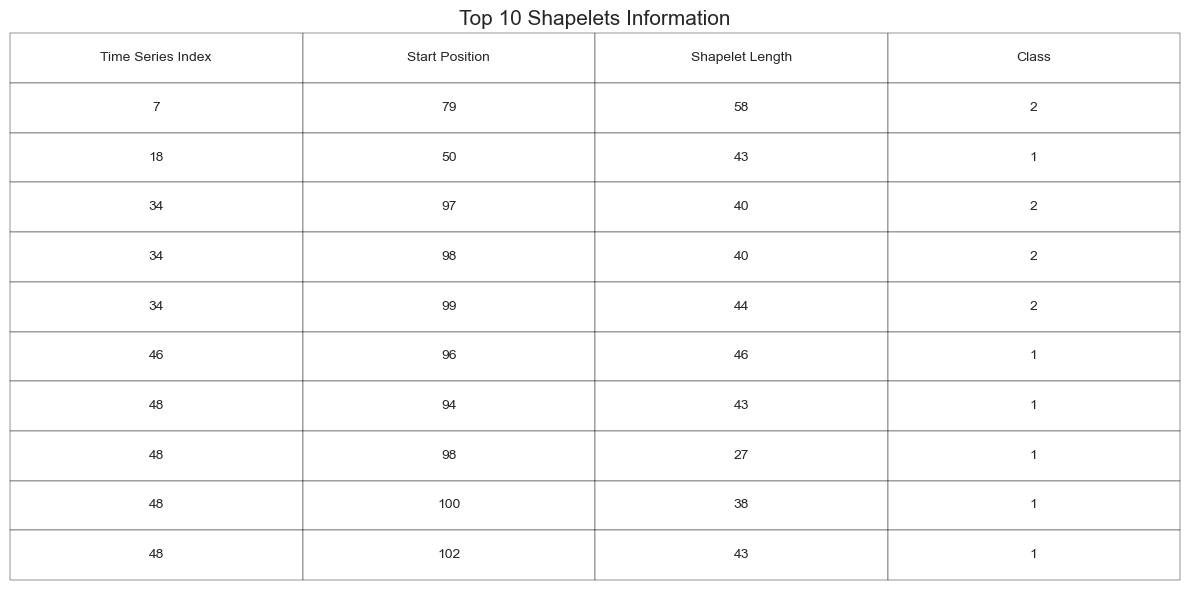

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for the top 10 shapelets
data = {
    "Time Series Index": time_series_indices[:num_shapelets],
    "Start Position": start_positions[:num_shapelets],
    "Shapelet Length": shapelet_lengths[:num_shapelets],
    "Class": shapelet_classes[:num_shapelets],  # New column for shapelet classes
}
df = pd.DataFrame(data)

# Define the priority order for sorting
priority_order = ["Time Series Index", "Start Position", "Shapelet Length", "Class"]

# Sort the DataFrame by the priority columns
df_sorted = df.sort_values(by=priority_order, ascending=True)

# Plot the table
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
ax.axis("off")  # Hide the axis

# Create the table
table = ax.table(
    cellText=df_sorted.values,
    colLabels=df_sorted.columns,
    cellLoc="center",
    loc="center",
    bbox=[0, 0, 1, 1],
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(df_sorted.columns)

plt.title("Top 10 Shapelets Information")
plt.tight_layout()
plt.show()

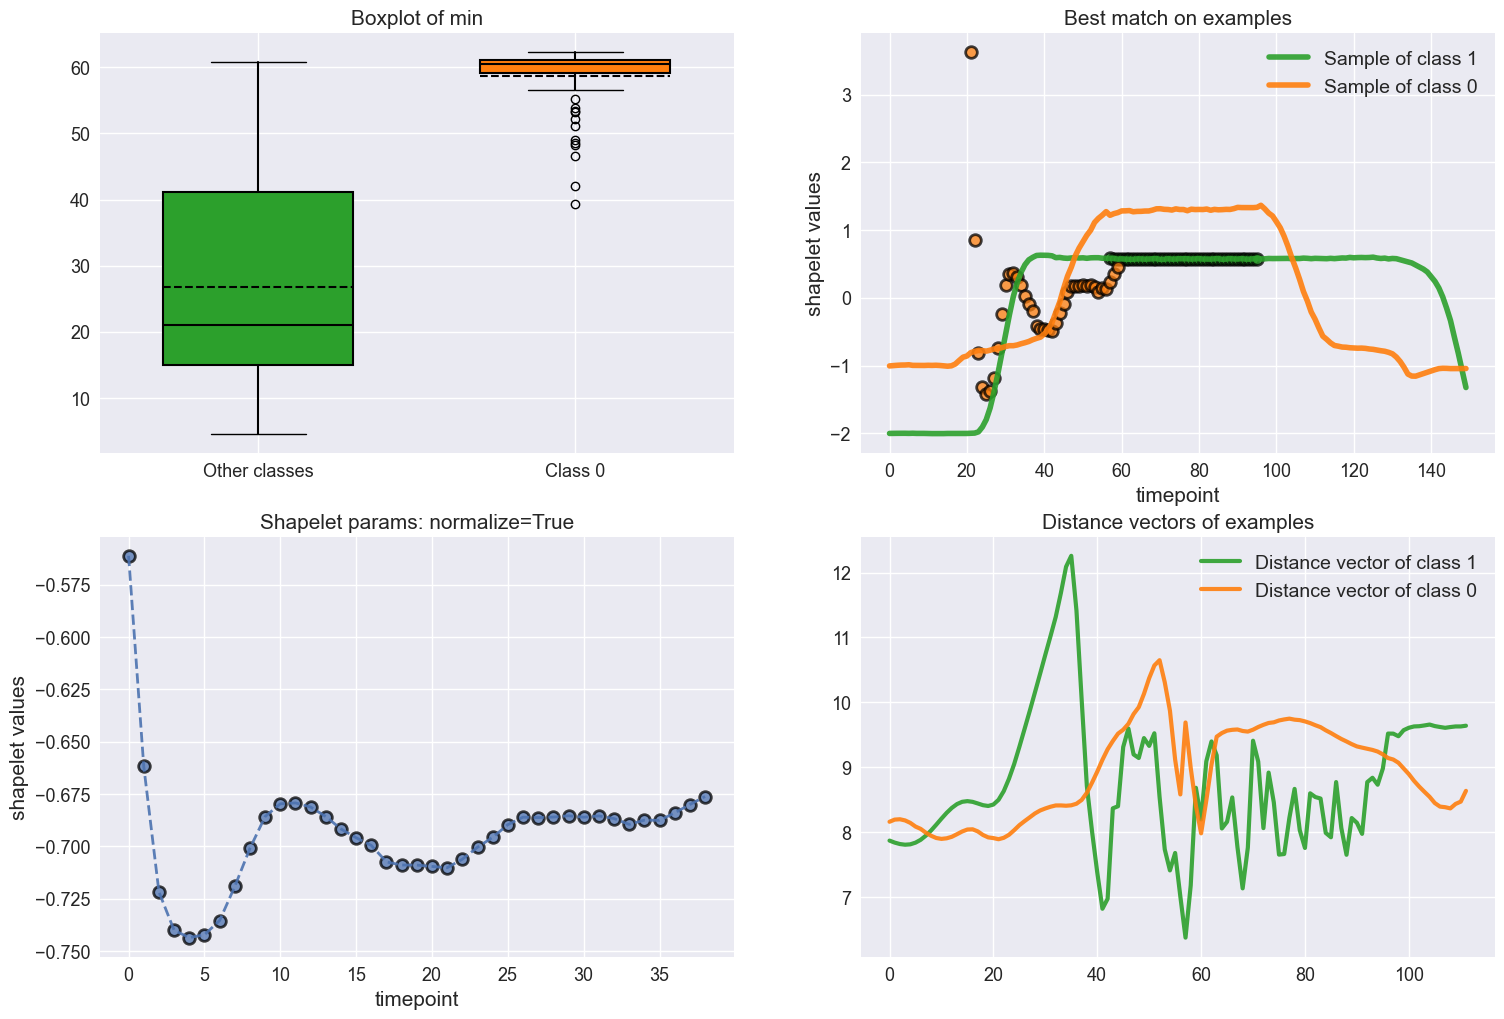

In [38]:
sast_rccv_vis = ShapeletClassifierVisualizer(sast_rccv)

fig = sast_rccv_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

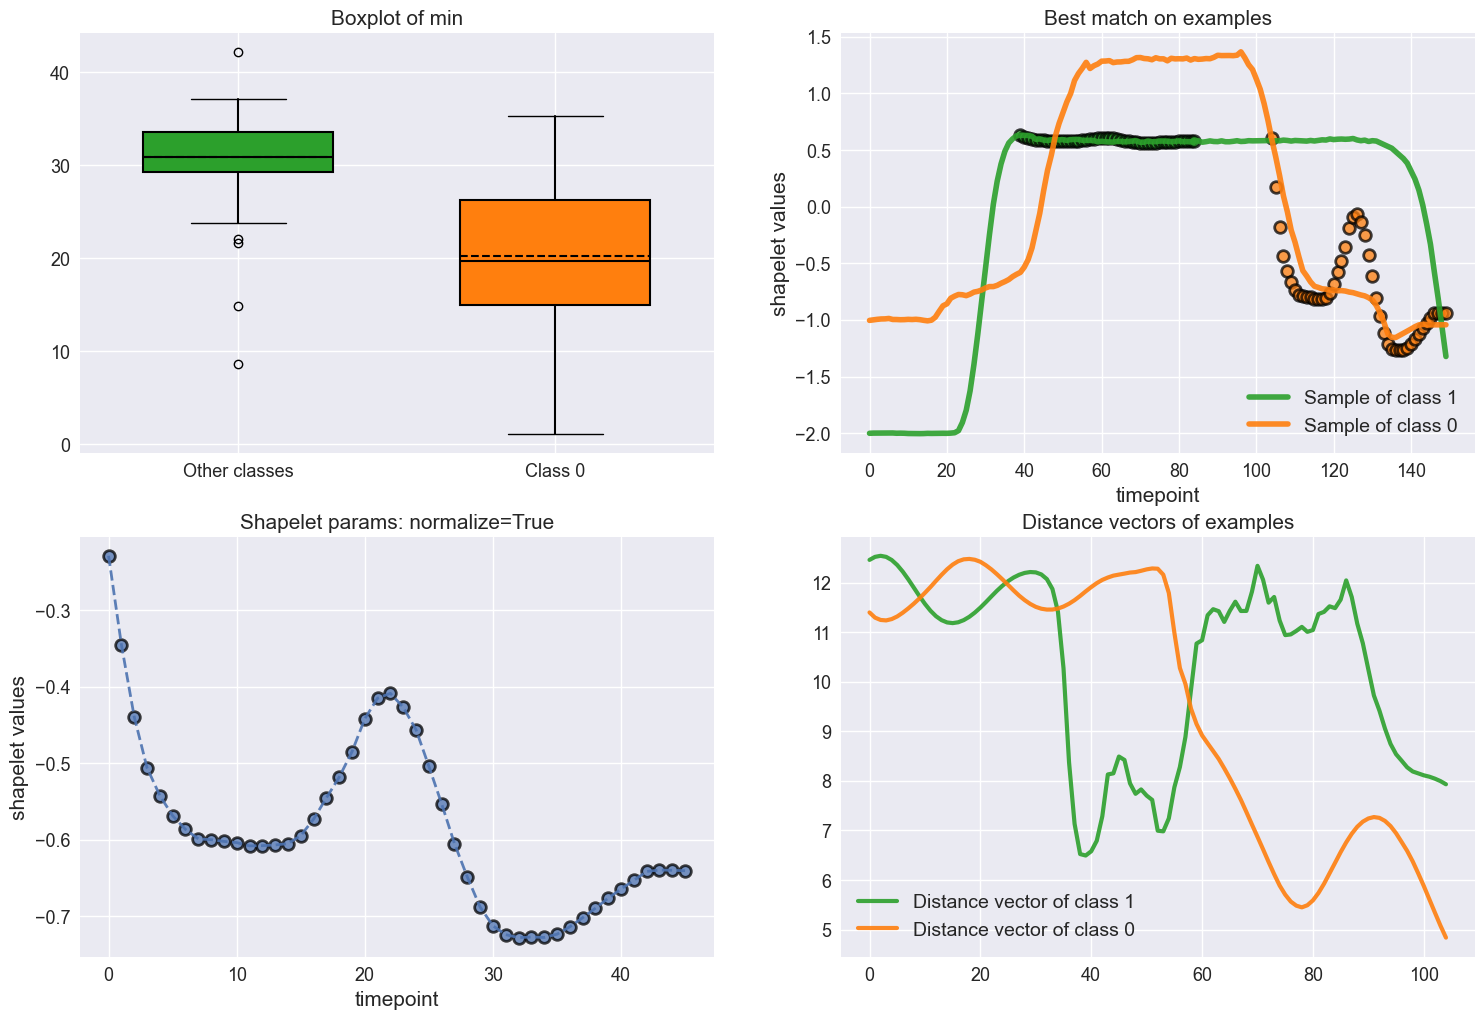

In [39]:
sast_rccv_vis = ShapeletClassifierVisualizer(sast_rccv)

fig = sast_rccv_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    best=False,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

In [40]:
# Filter shapelets by class
best_class_one_shp = [
    (shapelet, start_pos, index)
    for index, (shapelet, start_pos, cls) in enumerate(
        zip(top_subseries, start_positions, shapelet_classes)
    )
    if cls == "2"
][0]

print("Best class two shapelet is ranked", best_class_one_shp[2])

Best class two shapelet is ranked 0
